# Import packages

In [152]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import sys 
# sys.path.append("../..")
sys.path.append("diachronic-p2v") 
%aimport p2v

In [154]:
import pandas as pd
import numpy as np

In [ ]:
pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 20)

In [155]:
model = p2v.P2V()

data_dir:  /mnt/d/projects/diachronic-p2v/data
2024-11-16 15:02:20 -- start loading Mag_venue_info_df
2024-11-16 15:02:20 -- finish.
2024-11-16 15:02:20 -- start loading labeled_journal_info_df
2024-11-16 15:02:20 -- finish.


# Generate 7 ternary_df
Store 7 `ternary_df` into `ternary_df_list.pkl`

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def make_ternary_df(start_year, end_year):
    model.load_wv(start_year, end_year, 100, 10)
    VIDs = model.wv.index_to_key
    vectors = model.wv.get_normed_vectors()
    
    ternary_df = pd.DataFrame(list(zip(VIDs, vectors)), columns =['VID', 'vector'])
    VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
    ternary_df = ternary_df.loc[ternary_df.VID.isin(VID_labeled['VID'])]
    ternary_df['label'] = VID_labeled['label']
    
    ternary_df.loc[:,'venue_name'] = ternary_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])

    ternary_df.loc[ternary_df.label.isin(['Agricultural and Biological Sciences', 
                                          'Biochemistry, Genetics and Molecular Biology', 
                                          'Immunology and Microbiology', 
                                          'Neuroscience', 
                                          'Pharmacology, Toxicology and Pharmaceutics']), 'area'] = 'Life Science'
    ternary_df.loc[ternary_df.label.isin(['Medicine', 
                                          'Nursing',
                                          'Veterinary',
                                          'Dentistry',
                                          'Health Professions']), 'area'] = 'Health Science'
    ternary_df.loc[ternary_df.label.isin(['Chemical Engineering',
                                          'Chemistry',
                                          'Computer Science',
                                          'Earth and Planetary Sciences',
                                          'Energy',
                                          'Engineering',
                                          'Environmental Science',
                                          'Materials Science',
                                          'Mathematics',
                                          'Physics and Astronomy']), 'area'] = 'Physical Science'
    ternary_df.loc[ternary_df.label.isin(['Arts and Humanities',
                                          'Business, Management and Accounting',
                                          'Decision Sciences',
                                          'Economics, Econometrics and Finance',
                                          'Psychology',
                                          'Social Sciences']), 'area'] = 'Social Science'
    ternary_df.loc[ternary_df.label=='Multidisciplinary', 'area'] = 'Multidisciplinary'
    
    # add 5 artificial area average vectors
    pole_life = ternary_df[ternary_df.area == 'Life Science'].vector.mean()
    pole_health = ternary_df[ternary_df.area == 'Health Science'].vector.mean()
    pole_physical = ternary_df[ternary_df.area == 'Physical Science'].vector.mean()

    new_rows = pd.DataFrame([
        ['life_avg', pole_life, 'Pole', 'Life_AVG', 'Pole'],
        ['health_avg', pole_health, 'Pole', 'Health_AVG', 'Pole'],
        ['physical_avg', pole_physical, 'Pole', 'Physical_AVG', 'Pole'],
        ['multi_avg', ternary_df[ternary_df.area == 'Multidisciplinary'].vector.mean(), 'Pole', 'Multi_AVG', 'Pole'],
        ['social_avg', ternary_df[ternary_df.area == 'Social Science'].vector.mean(), 'Pole', 'Social_AVG', 'Pole']
        ], 
        columns=['VID', 'vector', 'label', 'venue_name', 'area'])
    ternary_df = pd.concat([ternary_df, new_rows], ignore_index=True)
    
    ternary_df['life_cs'] = ternary_df.vector.apply(lambda x: 
                                                    cosine_similarity(x.reshape(1, -1), pole_life.reshape(1, -1))[0][0])
    ternary_df['health_cs'] = ternary_df.vector.apply(lambda x: 
                                                      cosine_similarity(x.reshape(1, -1), pole_health.reshape(1, -1))[0][0])
    ternary_df['physical_cs'] = ternary_df.vector.apply(lambda x: 
                                                        cosine_similarity(x.reshape(1, -1), pole_physical.reshape(1, -1))[0][0])

    ternary_df[['life_cs', 'health_cs', 'physical_cs']] = ternary_df[['life_cs', 'health_cs', 'physical_cs']].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    ternary_df['cs_sum'] = ternary_df[['life_cs', 'health_cs', 'physical_cs']].sum(axis=1)
    ternary_df['life_cs'] = ternary_df['life_cs'] / ternary_df['cs_sum']
    ternary_df['health_cs'] = ternary_df['health_cs'] / ternary_df['cs_sum']
    ternary_df['physical_cs'] = ternary_df['physical_cs'] / ternary_df['cs_sum']
    ternary_df.drop(columns=['vector', 'cs_sum'], inplace=True)
    
    return ternary_df

In [60]:
ternary_df_list = []
for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = make_ternary_df(start_year, end_year)
    ternary_df_list.append(ternary_df)

2024-10-05 17:01:47 -- start loading word vectors...
2024-10-05 17:01:47 -- word vectors loaded, and its shape is: (1645, 100)
2024-10-05 17:01:47 -- start loading VID_labeled...
2024-10-05 17:01:47 -- finish.


2024-10-05 17:01:48 -- start loading word vectors...
2024-10-05 17:01:48 -- word vectors loaded, and its shape is: (3116, 100)
2024-10-05 17:01:48 -- start loading VID_labeled...
2024-10-05 17:01:48 -- finish.
2024-10-05 17:01:50 -- start loading word vectors...
2024-10-05 17:01:50 -- word vectors loaded, and its shape is: (5686, 100)
2024-10-05 17:01:50 -- start loading VID_labeled...
2024-10-05 17:01:50 -- finish.
2024-10-05 17:01:52 -- start loading word vectors...
2024-10-05 17:01:52 -- word vectors loaded, and its shape is: (9337, 100)
2024-10-05 17:01:52 -- start loading VID_labeled...
2024-10-05 17:01:52 -- finish.
2024-10-05 17:01:56 -- start loading word vectors...
2024-10-05 17:01:56 -- word vectors loaded, and its shape is: (15019, 100)
2024-10-05 17:01:56 -- start loading VID_labeled...
2024-10-05 17:01:56 -- finish.
2024-10-05 17:02:02 -- start loading word vectors...
2024-10-05 17:02:02 -- word vectors loaded, and its shape is: (27460, 100)
2024-10-05 17:02:02 -- start lo

In [61]:
import pickle

with open('ternary_df_list.pkl', 'wb') as f:
    pickle.dump(ternary_df_list, f)

# Plot scatters for 7 decades

In [5]:
import pickle

ternary_df_list = pickle.load(open('ternary_df_list.pkl', 'rb'))
ternary_df_list[0]

,VID,label,venue_name,area,life_cs,health_cs,physical_cs,cluster,cluster_label,label_area_match,sim_score
0,137773608.0,Multidisciplinary,Nature,Multidisciplinary,0.475300,0.194530,0.330170,1,Life Science,False,0.022901
1,140251998.0,"Biochemistry, Genetics and Molecular Biology",Journal of Biological Chemistry,Life Science,0.435674,0.369662,0.194664,0,Health Science,False,0.118609
2,111155417.0,"Biochemistry, Genetics and Molecular Biology",Journal of the American Chemical Society,Life Science,0.350457,0.277572,0.371970,1,Life Science,True,0.725191
3,54862371.0,Physics and Astronomy,Physical Review,Physical Science,0.203328,0.173030,0.623641,3,Physical Science,True,0.585799
4,3880285.0,Multidisciplinary,Science,Multidisciplinary,0.466711,0.333373,0.199916,1,Life Science,False,0.022901
...,...,...,...,...,...,...,...,...,...,...,...
1253,life_avg,Pole,Life_AVG,Pole,0.448206,0.283087,0.268707,1,Life Science,False,0.007634
1254,health_avg,Pole,Health_AVG,Pole,0.297157,0.475991,0.226852,0,Health Science,False,0.002045
1255,physical_avg,Pole,Physical_AVG,Pole,0.285027,0.228241,0.486732,3,Physical Science,False,0.003945
1256,multi_avg,Pole,Multi_AVG,Pole,0.451343,0.227130,0.321527,1,Life Science,False,0.007634


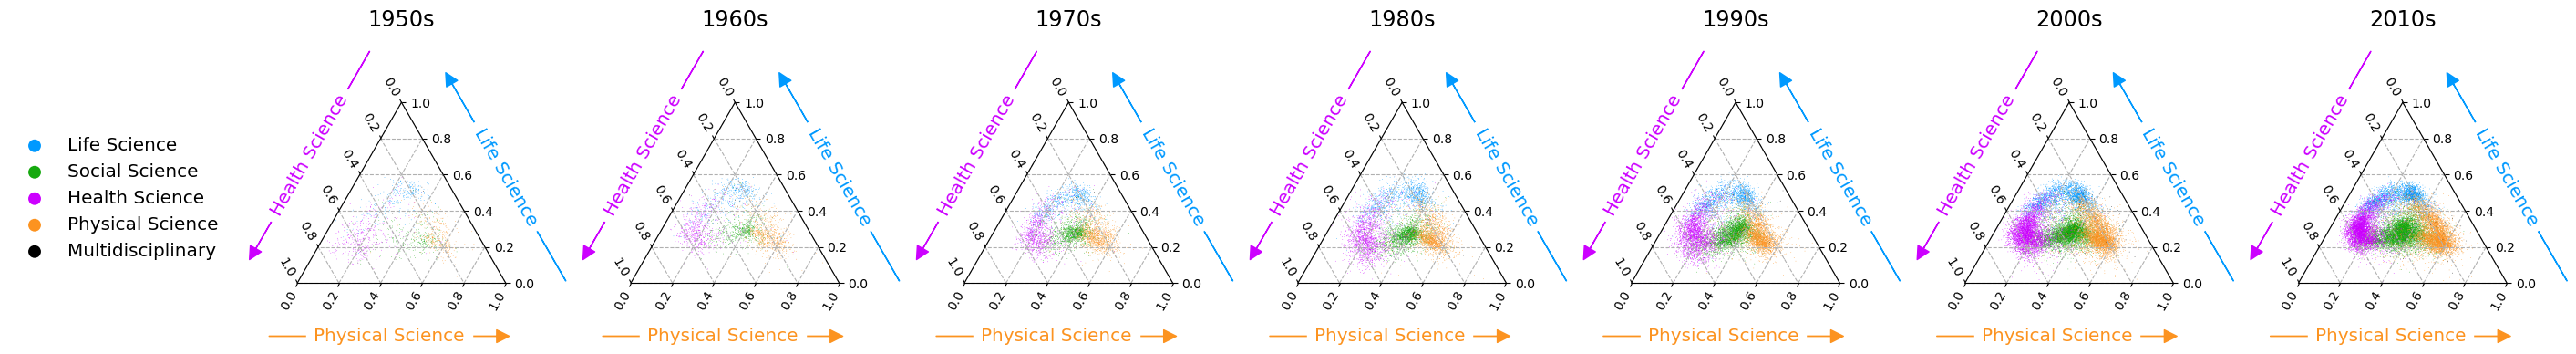

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle, FancyArrowPatch
import mpltern

fig1 = plt.figure(figsize=(36, 9))
fig1.subplots_adjust(wspace=0.6)

# Start of arrows in barycentric coordinates.
ta = np.array([ 0.0, -0.25,  1.1])
la = np.array([ 1.1,  0.0, -0.25])
ra = np.array([-0.25,  1.1,  0.0])

# End of arrows in barycentric coordinates.
tb = np.array([ 1.0, -0.25,  0.1])
lb = np.array([ 0.1,  1.0, -0.25])
rb = np.array([-0.25,  0.1,  1.0])

tpos = (ta + tb) * 0.5
lpos = (la + lb) * 0.5
rpos = (ra + rb) * 0.5

arrowstyle = ArrowStyle('simple', head_length=10, head_width=10)

for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    ax = fig1.add_subplot(1, 8, i -13, projection='ternary')
    
    kwargs_label = {
        'transform': ax.transTernaryAxes,
        'backgroundcolor': 'w',
        'ha': 'center',
        'va': 'center',
        'rotation_mode': 'anchor',
        'zorder': -9,  # A bit higher on arrows, but still lower than others.
        'fontsize': 'x-large'
    }
    
    f = ax.transAxesProjection.transform

    kwargs_arrow = {
    'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
    'arrowstyle': arrowstyle,
    'linewidth': 1,
    'clip_on': False,  # To plot arrows outside triangle
    'zorder': -10,  # Very low value not to hide e.g. tick labels.
    }

    tarrow = FancyArrowPatch(f(ta), f(tb), ec=model.area_color_dict['Life Science'], fc=model.area_color_dict['Life Science'], **kwargs_arrow)
    larrow = FancyArrowPatch(f(la), f(lb), ec=model.area_color_dict['Health Science'], fc=model.area_color_dict['Health Science'], **kwargs_arrow)
    rarrow = FancyArrowPatch(f(ra), f(rb), ec=model.area_color_dict['Physical Science'], fc=model.area_color_dict['Physical Science'], **kwargs_arrow)
    
    ax.add_patch(tarrow)
    ax.add_patch(larrow)
    ax.add_patch(rarrow)

    ax.text(*tpos, 'Life Science'  , color=model.area_color_dict['Life Science'], rotation=-60, **kwargs_label)
    ax.text(*lpos, 'Health Science' , color=model.area_color_dict['Health Science'], rotation=60, **kwargs_label)
    ax.text(*rpos, 'Physical Science', color=model.area_color_dict['Physical Science'], rotation=0, **kwargs_label)
    
    ax.grid(linestyle='--')

    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    ternary_df = ternary_df_list[i-15]

    for area in ['Life Science', 'Social Science', 'Health Science', 'Physical Science', 'Multidisciplinary']:
        tar_df = ternary_df[ternary_df.area == area]
        t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
        ax.scatter(t, l, r, label=area, marker='.', s=1, color=model.area_color_dict[area], edgecolors='none', alpha=1)

    ax.set_title(start_year+'s', pad=60, fontsize='xx-large')
    
ax.legend(markerscale=20, fontsize='x-large', edgecolor='white', bbox_to_anchor=(-10.5, 0.30, 0.6, 0.6))

plt.show()

In [13]:
fig1.savefig('7_decades_ternary_plot.pdf',
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# Distribution of periodicals' similarity to three corner vectors

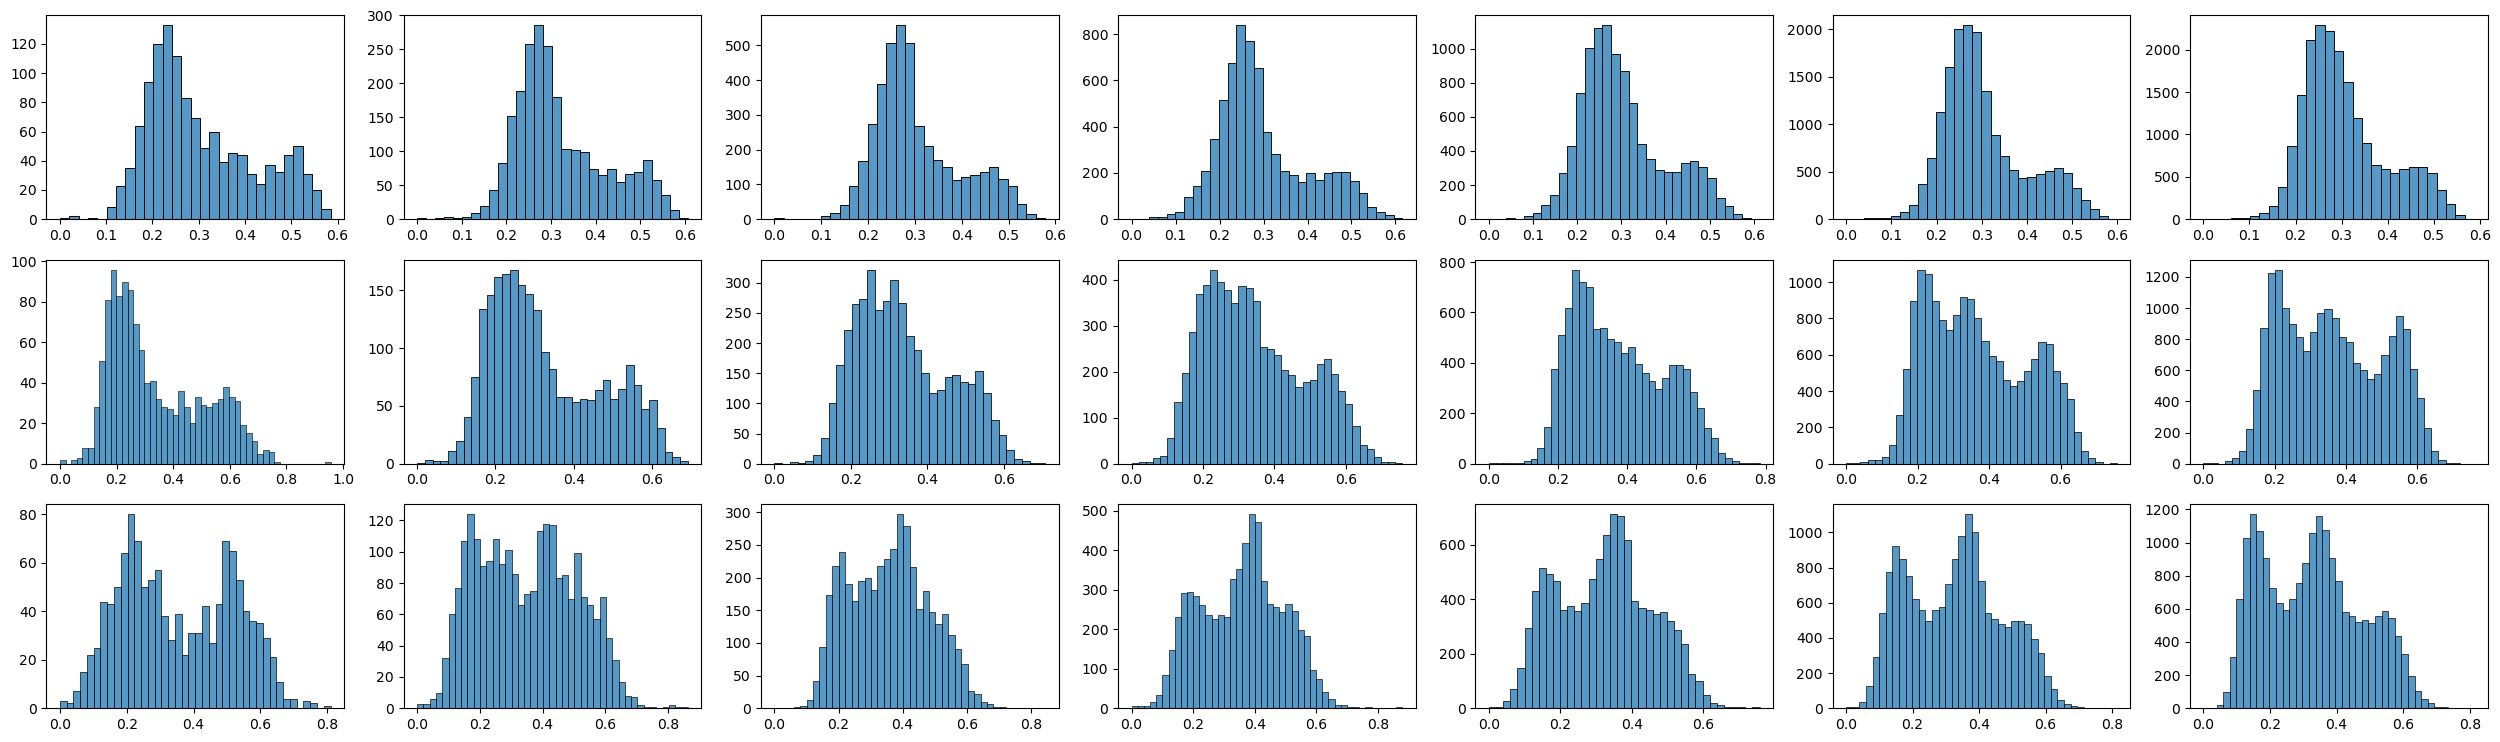

In [14]:
import seaborn as sns

var_list = ['life_cs', 'health_cs', 'physical_cs']

fig4 = plt.figure(figsize=(31.5, 9))
fig4.subplots_adjust(wspace=0.2)

for i, ternary_df in enumerate(ternary_df_list):
    for j, var in enumerate(var_list):
        ax = fig4.add_subplot(3, 7, i+j*7+1)
        hist = sns.histplot(ternary_df, x=var, element='bars', binwidth=0.02)
        hist.set(xlabel=None)
        hist.set(ylabel=None)

In [15]:
fig4.savefig('7_decade_ternary_dist.pdf',  
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# Clustering

In [64]:
import pickle

ternary_df_list = pickle.load(open('ternary_df_list.pkl', 'rb'))
ternary_df_list[0]

,VID,label,venue_name,area,life_cs,health_cs,physical_cs
0,137773608.0,Multidisciplinary,Nature,Multidisciplinary,0.475300,0.194530,0.330170
1,140251998.0,"Biochemistry, Genetics and Molecular Biology",Journal of Biological Chemistry,Life Science,0.435674,0.369662,0.194664
2,111155417.0,"Biochemistry, Genetics and Molecular Biology",Journal of the American Chemical Society,Life Science,0.350457,0.277572,0.371970
3,54862371.0,Physics and Astronomy,Physical Review,Physical Science,0.203328,0.173030,0.623641
4,3880285.0,Multidisciplinary,Science,Multidisciplinary,0.466711,0.333373,0.199916
...,...,...,...,...,...,...,...
1253,life_avg,Pole,Life_AVG,Pole,0.448206,0.283087,0.268707
1254,health_avg,Pole,Health_AVG,Pole,0.297157,0.475991,0.226852
1255,physical_avg,Pole,Physical_AVG,Pole,0.285027,0.228241,0.486732
1256,multi_avg,Pole,Multi_AVG,Pole,0.451343,0.227130,0.321527


In [65]:
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN

for ternary_df in ternary_df_list:
    features = ternary_df[['life_cs', 'health_cs', 'physical_cs']]

    # among different clustering algorithms, KMeans is the most stable one
    kmeans = KMeans(n_clusters=4, random_state=42)
    ternary_df['cluster'] = kmeans.fit_predict(features)

    # hdbscan = HDBSCAN(min_cluster_size=10, min_samples=5)
    # ternary_df['cluster'] = hdbscan.fit_predict(features)

    # dbscan = DBSCAN(eps=0.5)
    # ternary_df['cluster'] = dbscan.fit_predict(features)

    # 1. count the number of each label in each cluster
    cluster_label_counts = ternary_df.groupby('cluster')['area'].value_counts()
    # 2. create a dictionary that maps cluster to the label with the most counts
    cluster_to_label = cluster_label_counts.groupby(level=0).idxmax().apply(lambda x: x[1]).to_dict()
    # 3. rename the cluster according to the dictionary
    ternary_df['cluster_label'] = ternary_df['cluster'].map(cluster_to_label)
    # 4. create a new column to label whether cluster_label and area are the same
    ternary_df['label_area_match'] = ternary_df['cluster_label'] == ternary_df['area']

c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\lyuzhuoqi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


In [66]:
from clusim.clustering import Clustering
import clusim.sim as sim

for ternary_df in ternary_df_list:
    # Key: row index, val: value of 'area' column
    dict_original = {index: [row['area']] for index, row in ternary_df.iterrows()}
    # Key: row index, val: value of 'cluster_label' column
    dict_clustering = {index: [row['cluster_label']] for index, row in ternary_df.iterrows()}

    c_original = Clustering(elm2clu_dict = dict_original)
    c_clustering = Clustering(elm2clu_dict = dict_clustering)

    elementScores, relabeled_elements = sim.element_sim_elscore(c_original, c_clustering, alpha = 0.9)
    ternary_df['sim_score'] = elementScores

In [67]:
import pickle

# store the ternary_df_list, write clustering results to file
with open('ternary_df_list.pkl', 'wb') as f:
    pickle.dump(ternary_df_list, f)

# Load `ternary_df_list.pkl`

In [156]:
import pickle

ternary_df_list = pickle.load(open('diachronic-p2v/figures/ternary_plot/ternary_df_list.pkl', 'rb'))
ternary_df_list[0]

,VID,label,venue_name,area,life_cs,health_cs,physical_cs,cluster,cluster_label,label_area_match,sim_score
0,137773608.0,Multidisciplinary,Nature,Multidisciplinary,0.475300,0.194530,0.330170,1,Life Science,False,0.022901
1,140251998.0,"Biochemistry, Genetics and Molecular Biology",Journal of Biological Chemistry,Life Science,0.435674,0.369662,0.194664,0,Health Science,False,0.118609
2,111155417.0,"Biochemistry, Genetics and Molecular Biology",Journal of the American Chemical Society,Life Science,0.350457,0.277572,0.371970,1,Life Science,True,0.725191
3,54862371.0,Physics and Astronomy,Physical Review,Physical Science,0.203328,0.173030,0.623641,3,Physical Science,True,0.585799
4,3880285.0,Multidisciplinary,Science,Multidisciplinary,0.466711,0.333373,0.199916,1,Life Science,False,0.022901
...,...,...,...,...,...,...,...,...,...,...,...
1253,life_avg,Pole,Life_AVG,Pole,0.448206,0.283087,0.268707,1,Life Science,False,0.007634
1254,health_avg,Pole,Health_AVG,Pole,0.297157,0.475991,0.226852,0,Health Science,False,0.002045
1255,physical_avg,Pole,Physical_AVG,Pole,0.285027,0.228241,0.486732,3,Physical Science,False,0.003945
1256,multi_avg,Pole,Multi_AVG,Pole,0.451343,0.227130,0.321527,1,Life Science,False,0.007634


# Statiscs

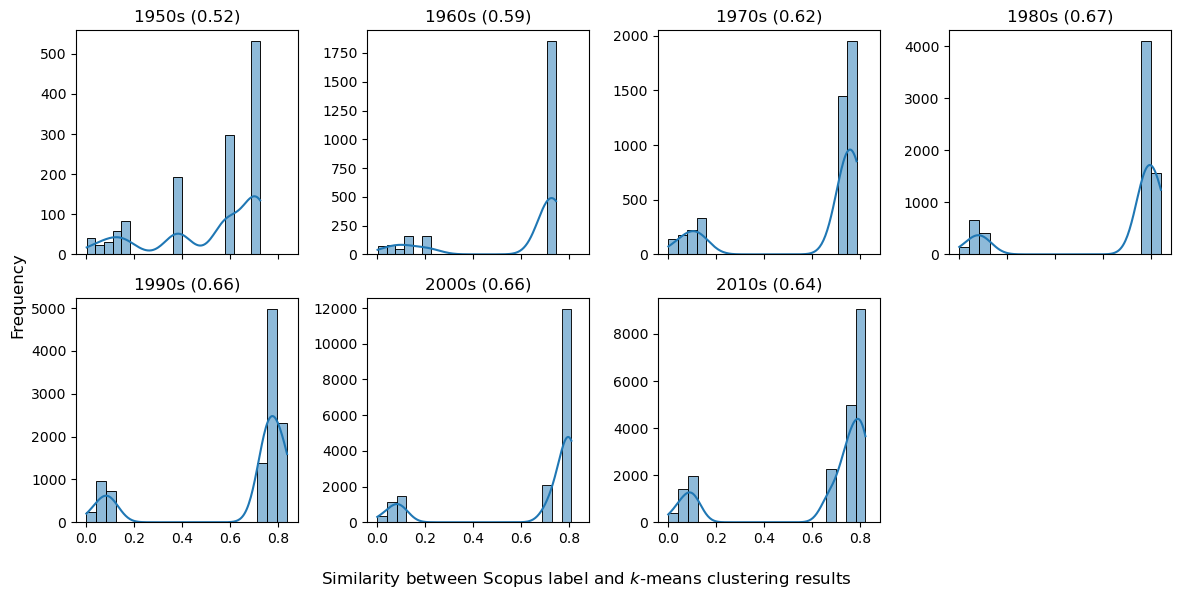

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 定义年代标签
decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

# 创建一个2行4列的子图布局 (留出空间)
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)
axes = axes.flatten()

# 绘制每个DataFrame中sim_score列的分布
for i, df in enumerate(ternary_df_list):
    # 计算平均sim_score
    mean_sim_score = df['sim_score'].mean()
    mean_sim_score_str = f"({mean_sim_score:.2f})"  # 格式化为小数点后两位

    sns.histplot(df['sim_score'], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"{decades[i]} {mean_sim_score_str}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
fig.supylabel('Frequency')  # 设置y轴标签
fig.supxlabel('Similarity between Scopus label and $k$-means clustering results')  # 设置x轴标签
# 删除最后一个空白子图（因为有2x4布局，但只有7个年代）
fig.delaxes(axes[-1])

# 调整布局使图形显示更紧凑
plt.tight_layout()
plt.show()

In [8]:
fig.savefig('sim_score_distribution.pdf',  
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

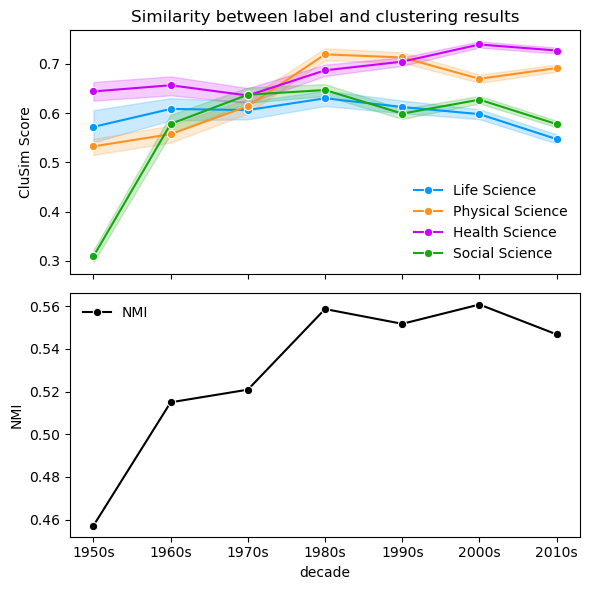

In [70]:
from sklearn.metrics import normalized_mutual_info_score

# 用于保存每个cluster的平均值
avg_match_list = []
NMI_list = []
decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

# 创建一个空的 DataFrame 来存储所有数据
combined_df = pd.DataFrame()
for i, ternary_df in enumerate(ternary_df_list):
    # drop rows with area eqaul to 'Pole' or 'Multidisciplinary'
    ternary_df_filtered = ternary_df.copy()[(ternary_df['area'] != 'Pole') & (ternary_df['area'] != 'Multidisciplinary')]

    nmi_score = normalized_mutual_info_score(ternary_df_filtered['area'], ternary_df_filtered['cluster_label'])
    NMI_list.append(nmi_score)

    ternary_df_filtered.loc[:,'decade'] = decades[i]  # 添加对应年代
    combined_df = pd.concat([combined_df, ternary_df_filtered])  # 将当前df追加到combined_df中
NMI_df = pd.DataFrame({'decade': decades, 'NMI': NMI_list})

fig2 = plt.figure(figsize=(6,6))
ax1 = fig2.add_subplot(2, 1, 1)
sns.lineplot(data=combined_df,
             x='decade',
             y='sim_score',
             hue='area',
             palette=area_color_dict,
             errorbar='ci',
             marker='o',
             ax=ax1)
ax1.set_title('Similarity between label and clustering results')
ax1.set_xlabel('')
ax1.set_xticklabels([])
ax1.set_ylabel('CluSim Score')
ax1.legend(frameon=False)

ax2 = fig2.add_subplot(2, 1, 2)
sns.lineplot(data=NMI_df, x='decade', y='NMI', marker='o', color='black', label='NMI', ax=ax2)
ax2.set_ylabel('NMI')
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()


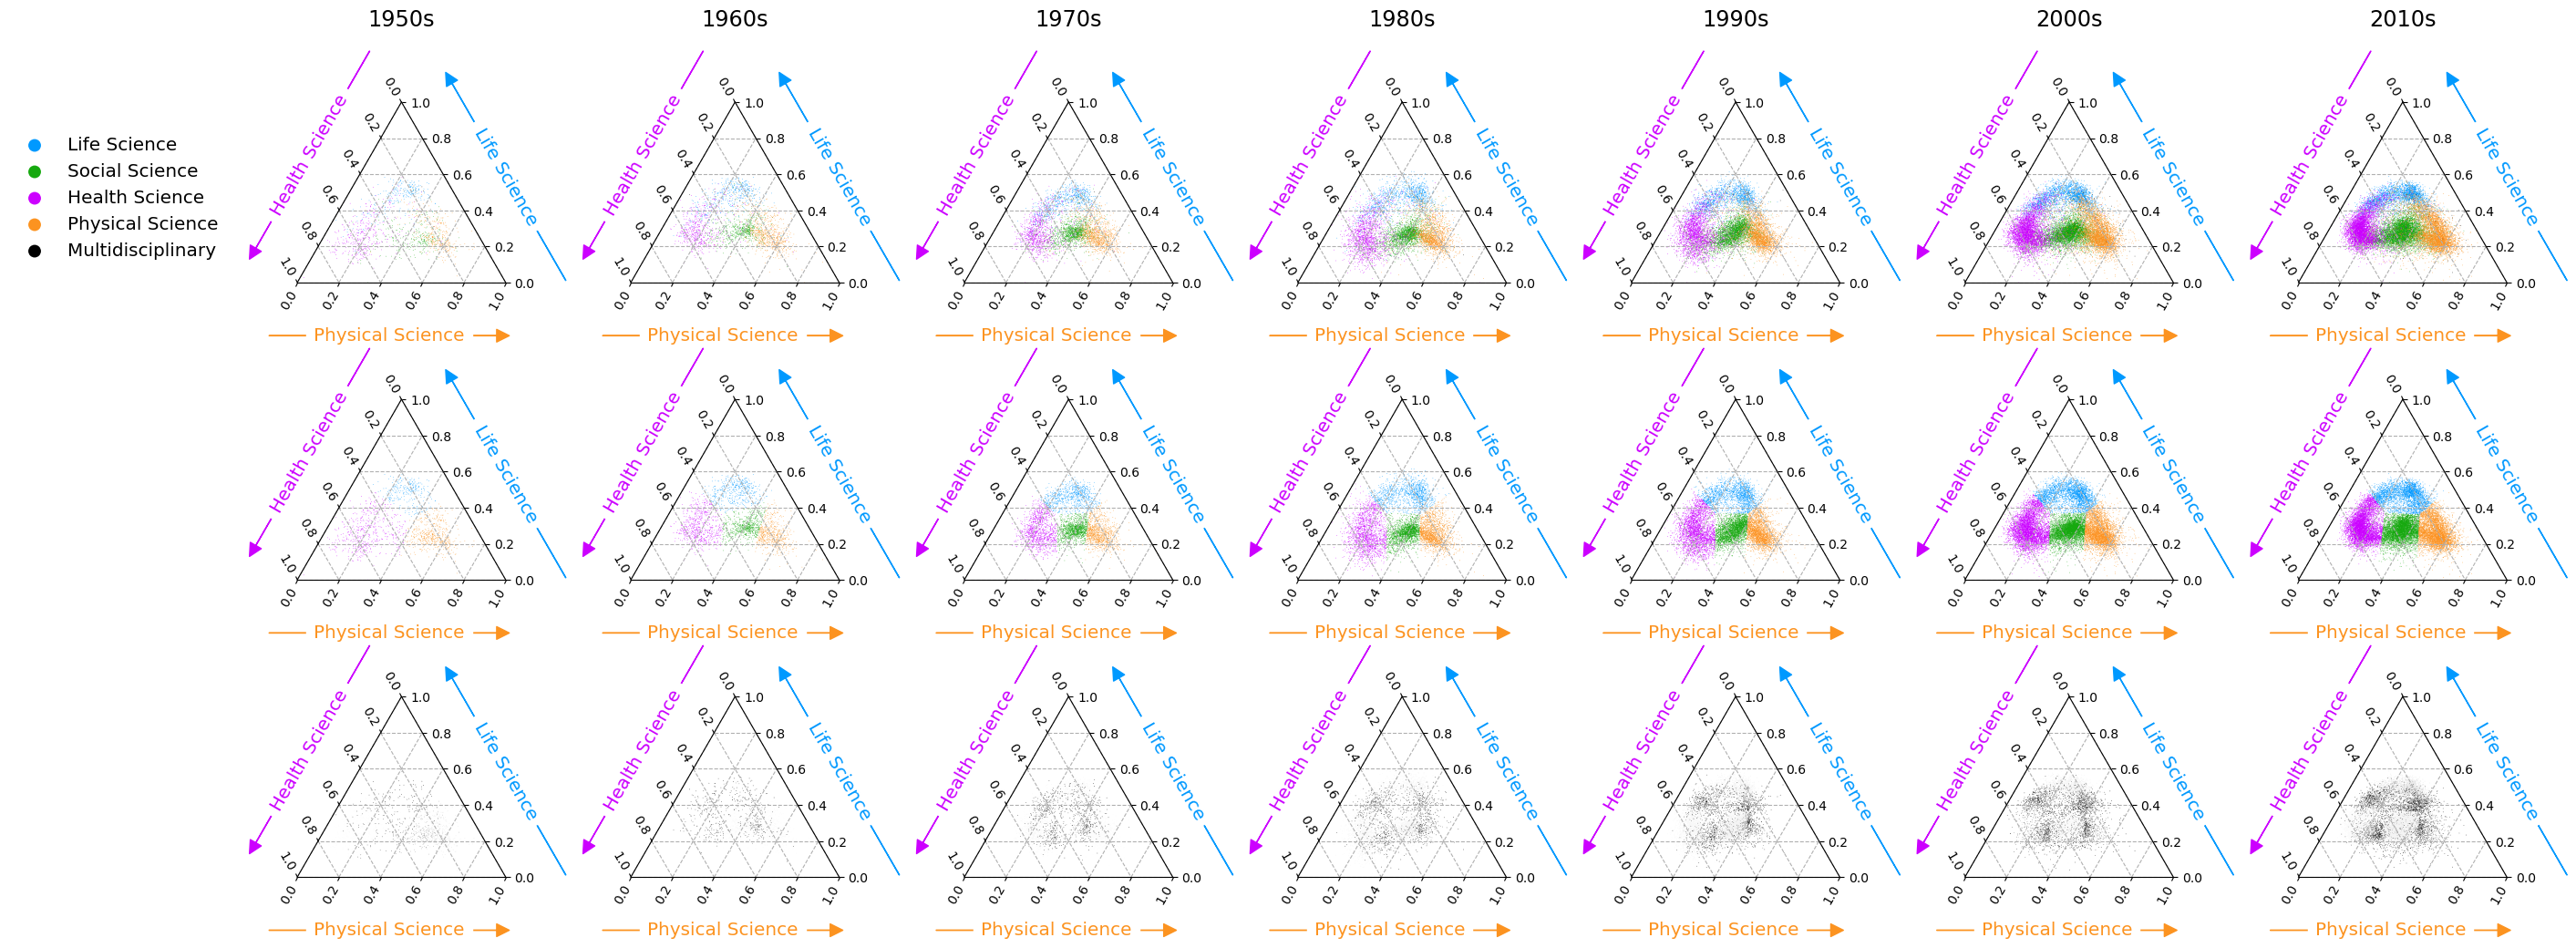

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle, FancyArrowPatch
import mpltern

fig3 = plt.figure(figsize=(36, 12))
fig3.subplots_adjust(wspace=0.6)

# Start of arrows in barycentric coordinates.
ta = np.array([ 0.0, -0.25,  1.1])
la = np.array([ 1.1,  0.0, -0.25])
ra = np.array([-0.25,  1.1,  0.0])

# End of arrows in barycentric coordinates.
tb = np.array([ 1.0, -0.25,  0.1])
lb = np.array([ 0.1,  1.0, -0.25])
rb = np.array([-0.25,  0.1,  1.0])

tpos = (ta + tb) * 0.5
lpos = (la + lb) * 0.5
rpos = (ra + rb) * 0.5

start_year_list = [str(year) for year in range(1950, 2020, 10)]
for i, ternary_df in enumerate(ternary_df_list):
    ax_up = fig3.add_subplot(3, 8, i+1, projection='ternary')
    ax_mid = fig3.add_subplot(3, 8, i+9, projection='ternary')
    ax_low = fig3.add_subplot(3, 8, i+17, projection='ternary')

    for ax in [ax_up, ax_mid, ax_low]:
        start_year = start_year_list[i]
        
        kwargs_label = {
            'transform': ax.transTernaryAxes,
            'backgroundcolor': 'w',
            'ha': 'center',
            'va': 'center',
            'rotation_mode': 'anchor',
            'zorder': -9,  # A bit higher on arrows, but still lower than others.
            'fontsize': 'x-large'
        }
        
        f = ax.transAxesProjection.transform

        kwargs_arrow = {
        'transform': ax.transAxes,  # Used with ``ax.transAxesProjection``
        'arrowstyle': arrowstyle,
        'linewidth': 1,
        'clip_on': False,  # To plot arrows outside triangle
        'zorder': -10,  # Very low value not to hide e.g. tick labels.
        }

        tarrow = FancyArrowPatch(f(ta), f(tb), ec=model.area_color_dict['Life Science'], fc=model.area_color_dict['Life Science'], **kwargs_arrow)
        larrow = FancyArrowPatch(f(la), f(lb), ec=model.area_color_dict['Health Science'], fc=model.area_color_dict['Health Science'], **kwargs_arrow)
        rarrow = FancyArrowPatch(f(ra), f(rb), ec=model.area_color_dict['Physical Science'], fc=model.area_color_dict['Physical Science'], **kwargs_arrow)
        
        ax.add_patch(tarrow)
        ax.add_patch(larrow)
        ax.add_patch(rarrow)
        
        ax.text(*tpos, 'Life Science'  , color=model.area_color_dict['Life Science'], rotation=-60, **kwargs_label)
        ax.text(*lpos, 'Health Science' , color=model.area_color_dict['Health Science'], rotation=60, **kwargs_label)
        ax.text(*rpos, 'Physical Science', color=model.area_color_dict['Physical Science'], rotation=0, **kwargs_label)
        
        ax.grid(linestyle='--')

    # plot the actual scatters in the top axis
    for area in ['Life Science', 'Social Science', 'Health Science', 'Physical Science', 'Multidisciplinary']:
        tar_df = ternary_df[ternary_df.area == area]
        t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
        ax_up.scatter(t, l, r, label=area, marker='.', s=1, color=model.area_color_dict[area], edgecolors='none', alpha=1)
    ax_up.set_title(start_year+'s', pad=60, fontsize='xx-large')
    # plot the clustering resutls in the middle axis
    for cluster_label in ['Life Science', 'Social Science', 'Health Science', 'Physical Science']:
        tar_df = ternary_df[ternary_df.cluster_label == cluster_label]
        t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
        ax_mid.scatter(t, l, r, label=cluster_label, marker='.', s=1, color=model.area_color_dict[cluster_label], edgecolors='none', alpha=1)
    # plot the CluSim scores in the bottom axis
    t, l, r = ternary_df.life_cs, ternary_df.health_cs, ternary_df.physical_cs
    ax_low.scatter(t, l, r, marker='.', s=1, c=[-x for x in ternary_df['sim_score']], cmap='Greys', edgecolors='none', alpha=1)

ax_up.legend(markerscale=20, fontsize='x-large', edgecolor='white', bbox_to_anchor=(-10.5, 0.30, 0.6, 0.6))

plt.show()

# CluSim IDW interpolation

In [157]:
# check the min/max values of sim_socre, to determine the color scale
for ternary_df in ternary_df_list:
    print(ternary_df.sim_score.max(), ternary_df.sim_score.min())

0.7251908396946565 0.0019723865877712132
0.7457627118644068 0.001494768310911887
0.7857142857142857 0.0007923930269412294
0.8414568826995179 0.0005035246727090881
0.8375542691751084 0.0003330003330003217
0.8097580169191423 0.00019673421207955233
0.8225616921269094 0.0001631853785899473


In [187]:
import math
import numpy as np

def ternary_to_cartesian(A, B, C):
    X = 0.5 * (A + 2 * B)
    Y = (math.sqrt(3) / 2) * A
    
    return X, Y

resolution = 128 # grid resolution

A_vals = np.linspace(0, 1, resolution)
B_vals = np.linspace(0, 1, resolution)
A_mesh, B_mesh = np.meshgrid(A_vals, B_vals)
C_mesh = 1 - A_mesh - B_mesh

mask = C_mesh >= 0
A_mesh = A_mesh[mask]
B_mesh = B_mesh[mask]
C_mesh = C_mesh[mask]
print('num of coords:', A_mesh.shape)

pred_x, pred_y = ternary_to_cartesian(A_mesh, B_mesh, C_mesh)

num of coords: (8246,)


In [159]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)
    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power
    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)

In [ ]:
decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
pred_z_list = []
mean_z_list = []

for i, ternary_df in enumerate(ternary_df_list):
    print('start processing', decades[i])
    ternary_df = ternary_df[ternary_df['area']!='Pole']
    mean_z_list.append(ternary_df['sim_score'].mean())
    
    ternary_df = ternary_df.assign(
        x=ternary_df.apply(lambda row: ternary_to_cartesian(row["life_cs"], row["health_cs"], row["physical_cs"])[0], axis=1),
        y=ternary_df.apply(lambda row: ternary_to_cartesian(row["life_cs"], row["health_cs"], row["physical_cs"])[1], axis=1)
    )

    pred_z = simple_idw(ternary_df["x"], ternary_df["y"], ternary_df["sim_score"], pred_x, pred_y, power=2)
    pred_z_list.append(pred_z)
    print('finish processing', decades[i])

start processing 1950s
finish processing 1950s
start processing 1960s
finish processing 1960s
start processing 1970s
finish processing 1970s
start processing 1980s
finish processing 1980s
start processing 1990s
finish processing 1990s
start processing 2000s
finish processing 2000s
start processing 2010s
finish processing 2010s


In [161]:
# calculate the mean of the interpolated values, to map the netural value to white
pred_z_mean = np.mean(np.vstack(pred_z_list))
pred_z_mean

0.622606987049212

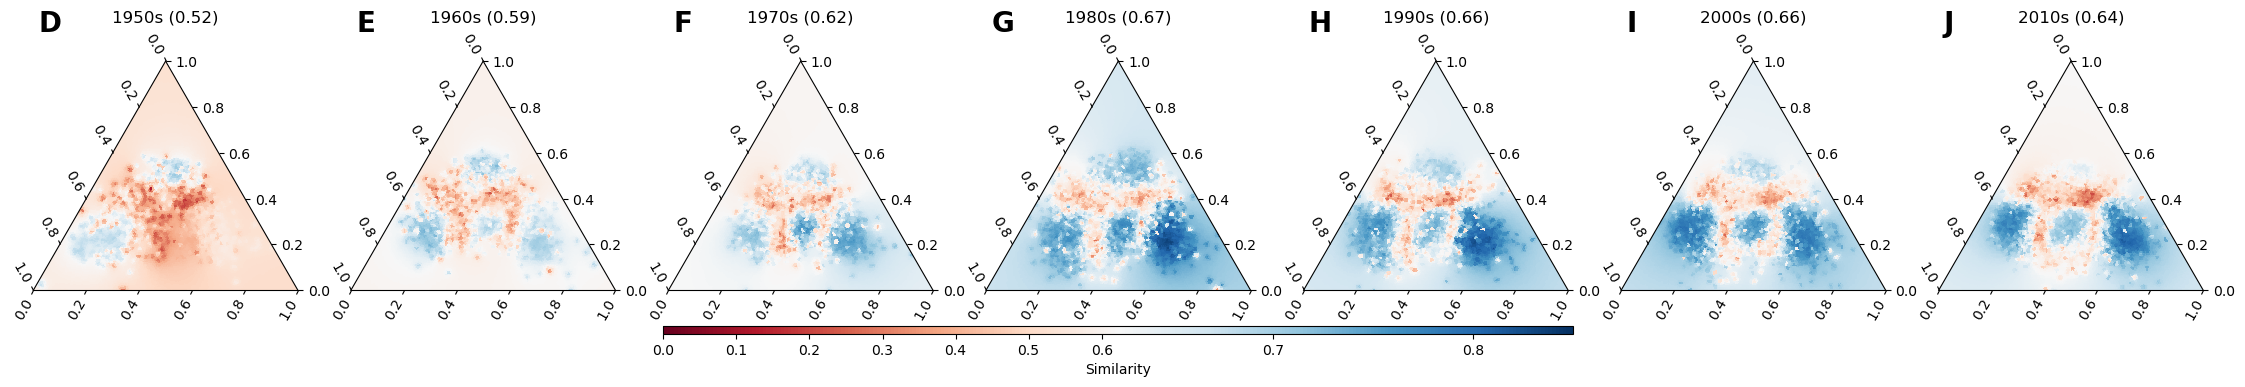

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import mpltern
import string

cmap = plt.get_cmap('RdBu')
vmin, vmax = 0.0, 0.85
midpoint = pred_z_mean        
# use TwoSlopeNorm to ensure 0 is mapped to the neutral color in the cmap 在 0
norm = TwoSlopeNorm(vcenter=midpoint, vmin=vmin, vmax=vmax)

fig4 = plt.figure(figsize=(28, 4))

for i, decade in enumerate(decades):
    t, l, r = A_mesh, B_mesh, C_mesh
    v = pred_z_list[i]
    
    ax = fig4.add_subplot(1, 7, i+1, projection='ternary')
    # cs = ax.tricontourf(t, l, r, v, levels=18, cmap=cmap, norm=norm)
    cs = ax.tripcolor(t, l, r, v, shading='flat', cmap=cmap, norm=norm)
    ax.set_title(f'{decades[i]} ({mean_z_list[i]:.2f})')
    
    # Color bar on the right
    # if i == len(decades) - 1:
    #     cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
    #     colorbar = fig4.colorbar(cs, cax=cax)
    #     colorbar.set_label('Similarity', rotation=270, va='baseline')

    # Color bar on the bottom
    if i == len(decades) - 1:
        # 在所有子图下方添加一个水平的colorbar
        cax = fig4.add_axes([0.35, 0.1, 0.325, 0.02])  # [left, bottom, width, height]
        colorbar = fig4.colorbar(cs, cax=cax, orientation='horizontal')
        colorbar.set_label('Similarity')
    
    # add pannel label（A, B, C...）
    panel_label = string.ascii_uppercase[i+3]  # get the letter from the alphabet
    ax.text(0.02, 1.225, panel_label, transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='left')

plt.show()

The following 2 cells are used for picking interdisplinary periodicals

In [7]:
ternary_df = ternary_df_list[-1]
ternary_df[(ternary_df.life_cs > 0.4) & (ternary_df.life_cs < 0.5) &
           (ternary_df.health_cs > 0.45) & (ternary_df.health_cs < 0.55) &
           (ternary_df.physical_cs > 0.10) & (ternary_df.physical_cs < 0.20) &
           (ternary_df.area != ternary_df.cluster_label)].sort_values(by='sim_score', ascending=True).head(20)

,VID,label,venue_name,area,life_cs,health_cs,physical_cs,cluster,cluster_label,label_area_match,sim_score
374,96638545.0,Neuroscience,Brain Research,Life Science,0.409188,0.455970,0.134842,0,Health Science,False,0.081919
10385,2764642421.0,"Biochemistry, Genetics and Molecular Biology",Genes and Diseases,Life Science,0.418434,0.456621,0.124945,0,Health Science,False,0.081919
9867,183475463.0,Immunology and Microbiology,Immunity & Ageing,Life Science,0.405841,0.490190,0.103969,0,Health Science,False,0.081919
9527,152803389.0,"Biochemistry, Genetics and Molecular Biology",Growth Factors Journal,Life Science,0.412467,0.469284,0.118249,0,Health Science,False,0.081919
8430,2756415187.0,"Pharmacology, Toxicology and Pharmaceutics",Journal of basic and clinical physiology and pharmacology,Life Science,0.439256,0.451863,0.108881,0,Health Science,False,0.081919
7828,19733918.0,Immunology and Microbiology,International Reviews of Immunology,Life Science,0.428919,0.463177,0.107904,0,Health Science,False,0.081919
7795,2765071679.0,"Biochemistry, Genetics and Molecular Biology",Clinical and translational medicine,Life Science,0.405507,0.493105,0.101388,0,Health Science,False,0.081919
10391,3096383.0,"Pharmacology, Toxicology and Pharmaceutics",Systematic Reviews in Pharmacy,Life Science,0.406717,0.450886,0.142396,0,Health Science,False,0.081919
7681,25199142.0,Immunology and Microbiology,Archivum Immunologiae Et Therapiae Experimentalis,Life Science,0.437578,0.458898,0.103524,0,Health Science,False,0.081919
6757,184974454.0,"Biochemistry, Genetics and Molecular Biology",Indian Journal of Clinical Biochemistry,Life Science,0.426646,0.462618,0.110736,0,Health Science,False,0.081919


In [8]:
ternary_df = ternary_df_list[-1]
ternary_df[(ternary_df.cluster_label == 'Social Science') &
           (ternary_df.area == 'Physical Science')].sort_values(by='sim_score', ascending=True).head(20)

,VID,label,venue_name,area,life_cs,health_cs,physical_cs,cluster,cluster_label,label_area_match,sim_score
82,163807576.0,Materials Science,Biomaterials,Physical Science,0.361836,0.325144,0.313020,3,Social Science,False,0.062265
13438,2898133657.0,Engineering,Current Opinion in Biomedical Engineering,Physical Science,0.322142,0.393786,0.284073,3,Social Science,False,0.062265
13437,2737714521.0,Engineering,Biomaterials Research,Physical Science,0.362105,0.376044,0.261851,3,Social Science,False,0.062265
13431,105581714.0,Computer Science,Australasian Journal of Information Systems,Physical Science,0.227824,0.401352,0.370825,3,Social Science,False,0.062265
13430,154825595.0,Engineering,Smpte Motion Imaging Journal,Physical Science,0.212645,0.323382,0.463972,3,Social Science,False,0.062265
13415,2764846206.0,Environmental Science,Jàmbá: Journal of Disaster Risk Studies,Physical Science,0.331869,0.306990,0.361141,3,Social Science,False,0.062265
13368,151276642.0,Mathematics,Statistical Inference for Stochastic Processes,Physical Science,0.245875,0.326389,0.427735,3,Social Science,False,0.062265
13251,39868070.0,Computer Science,Journal of Systems and Information Technology,Physical Science,0.239923,0.306262,0.453816,3,Social Science,False,0.062265
13247,120609085.0,Mathematics,Logica Universalis,Physical Science,0.257403,0.306532,0.436065,3,Social Science,False,0.062265
13082,110189822.0,Computer Science,Journal of Data and Information Quality,Physical Science,0.239286,0.318763,0.441951,3,Social Science,False,0.062265


In [27]:
venue_list = ['International Journal of Immunogenetics',
              'International Journal of Molecular Sciences',
              
              'Psychodynamic Practice',
              'Policy and practice in health and safety',

              'Journal of Molecular Modeling',
              'Journal of Applied Crystallography',

              'Journal of Mathematics and Music',
              'Journal of Data and Information Quality',
              ]

# abbr_list = ['Int. J. Immunogenet.',
#              'Int. J. Mol. Sci.',
                
#              'Psychodyn. Pract.',
#              'Policy Pract. Health Saf.',
             
#              'J. Mol. Model.',
#              'J. Appl. Crystallogr.',
    
#              'J. Math. Music',
#              'J. Data Inf. Qual.',
#              ]

abbr_list = ['International Journal of Immunogenetics',
             'International Journal of Molecular Sciences',
             
             'Psychodynamic Practice',
             'Policy and Practice in Health and Safety',

             'Journal of Molecular Modeling',
             'Journal of Applied Crystallography',

             'Journal of Mathematics and Music',
             'Journal of Data and Information Quality',
             ]

color_list = []
edgecolor_list = []

for venue in venue_list:
    color_list.append(model.area_color_dict[ternary_df[ternary_df.venue_name == venue].cluster_label.values[0]])
    edgecolor_list.append(model.area_color_dict[ternary_df[ternary_df.venue_name == venue].area.values[0]])

In [10]:
# checking examplary periodicals' coordinates
ternary_df[ternary_df.venue_name.isin(venue_list)]

,VID,label,venue_name,area,life_cs,health_cs,physical_cs,cluster,cluster_label,label_area_match,sim_score
91,10623703.0,Medicine,International Journal of Molecular Sciences,Health Science,0.491744,0.347813,0.160443,2,Life Science,False,0.046477
633,79162954.0,"Biochemistry, Genetics and Molecular Biology",Journal of Applied Crystallography,Life Science,0.366751,0.142914,0.490335,1,Physical Science,False,0.008853
1541,113170167.0,Chemistry,Journal of Molecular Modeling,Physical Science,0.383765,0.212441,0.403794,2,Life Science,False,0.103016
7506,44859635.0,Immunology and Microbiology,International Journal of Immunogenetics,Life Science,0.428454,0.463460,0.108086,0,Health Science,False,0.081919
13082,110189822.0,Computer Science,Journal of Data and Information Quality,Physical Science,0.239286,0.318763,0.441951,3,Social Science,False,0.062265
14480,69301584.0,Psychology,Psychodynamic Practice,Social Science,0.202854,0.534041,0.263105,0,Health Science,False,0.108868
15657,198288194.0,Arts and Humanities,Journal of Mathematics and Music,Social Science,0.269029,0.245196,0.485776,1,Physical Science,False,0.103335
16039,2764658907.0,Medicine,Policy and practice in health and safety,Health Science,0.174051,0.504382,0.321567,3,Social Science,False,0.037932


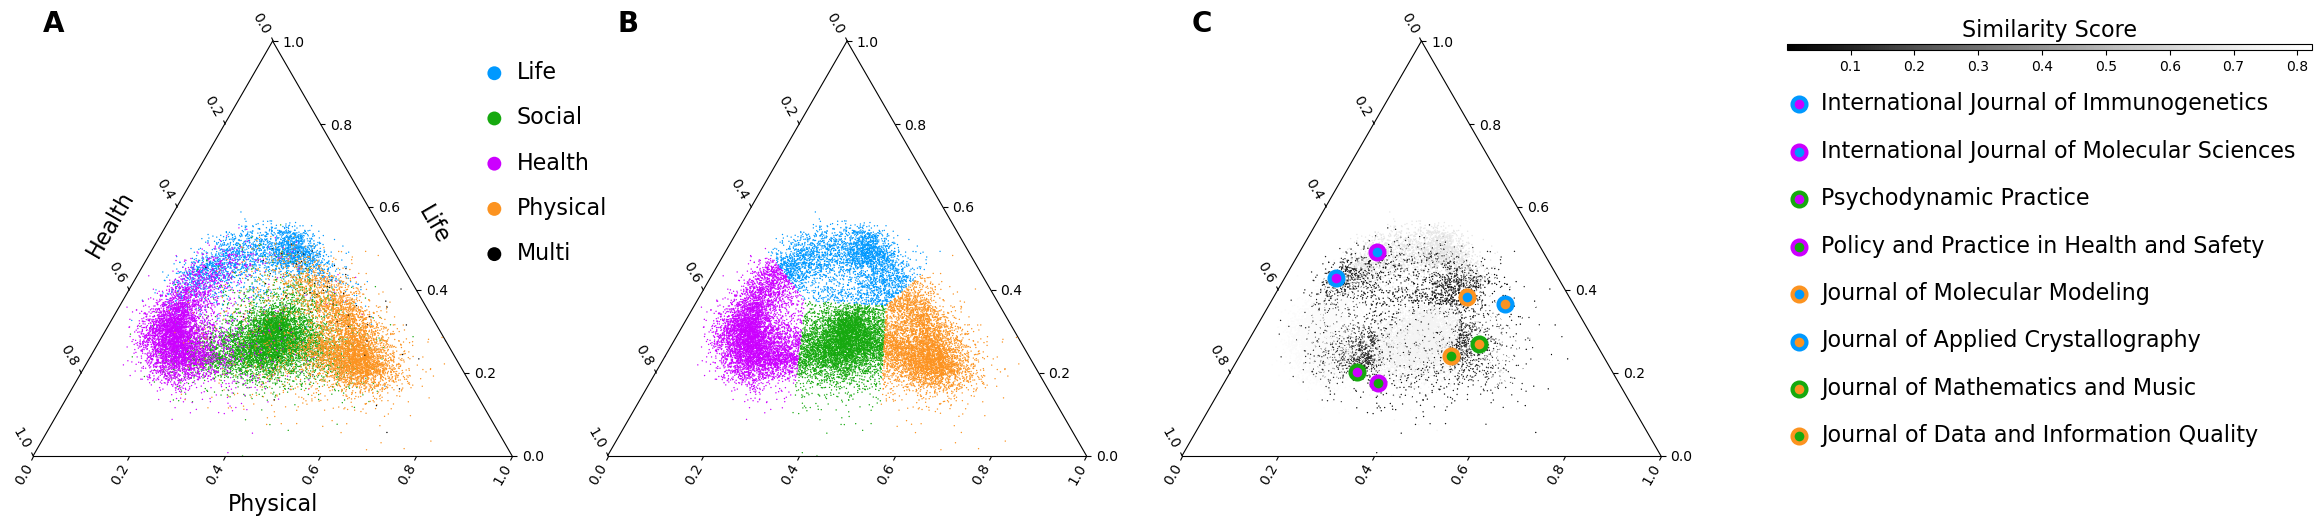

In [64]:
import matplotlib.pyplot as plt
import mpltern
import string

ternary_df = ternary_df_list[-1]

fig5 = plt.figure(figsize=(21, 6))
ax_list = []

ax_1 = fig5.add_subplot(1,3, 1, projection='ternary')
ax_list.append(ax_1)
for area in ['Life Science', 'Social Science', 'Health Science', 'Physical Science', 'Multidisciplinary']:
    tar_df = ternary_df[ternary_df.area == area]
    t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
    pc_1 = ax_1.scatter(t, l, r, s=1, label=model.area_abbr_dict[area], color=model.area_color_dict[area], edgecolors='none')
ax_1.legend(frameon=False, markerscale=10, bbox_to_anchor=(0.875, 1.0), fontsize=16, labelspacing=1.0, handletextpad=0)
ax_1.set_tlabel('Life', fontsize=16)
ax_1.set_llabel('Health', fontsize=16)
ax_1.set_rlabel('Physical', fontsize=16)
ax_1.taxis.set_label_position('tick1')
ax_1.laxis.set_label_position('tick1')
ax_1.raxis.set_label_position('tick1')

ax_2 = fig5.add_subplot(1, 3, 2, projection='ternary')
ax_list.append(ax_2)
for cluster_label in ['Life Science', 'Social Science', 'Health Science', 'Physical Science']:
    tar_df = ternary_df[ternary_df.cluster_label == cluster_label]
    t, l, r = tar_df.life_cs, tar_df.health_cs, tar_df.physical_cs
    pc_2 = ax_2.scatter(t, l, r, s=1, color=model.area_color_dict[cluster_label], edgecolors='none')

ax_3 = fig5.add_subplot(1, 3, 3, projection='ternary')
ax_list.append(ax_3)
t, l, r = ternary_df['life_cs'], ternary_df['health_cs'], ternary_df['physical_cs']

pc_3 = ax_3.scatter(t, l, r, s=1, c=ternary_df['sim_score'], cmap='Greys_r', edgecolors='none')
for i, venue in enumerate(venue_list):
    tar_df = ternary_df[ternary_df['venue_name'] == venue]
    t, l, r = tar_df['life_cs'], tar_df['health_cs'], tar_df['physical_cs']
    pc_4 = ax_3.scatter(t, l, r, label=abbr_list[i], s=100, linewidths=3, c=color_list[i], edgecolors=edgecolor_list[i])
ax_3.legend(frameon=False, bbox_to_anchor=(1.2, 0.925), fontsize=16, labelspacing=1.1, handletextpad=0)

# cax = fig5.add_axes([0.9, 0.2, 0.005, 0.6])
# cbar = fig5.colorbar(pc_3, cax=cax, orientation='vertical', shrink=0.6, pad=0.05)
# cbar.set_label('Similarity Score', fontsize=16, labelpad=-50, y=0.5, rotation=90)

cax = fig5.add_axes([0.96, 0.825, 0.25, 0.01])  # [left, bottom, width, height]
cbar = fig5.colorbar(pc_3, cax=cax, orientation='horizontal', shrink=0.6, pad=0.05)
cbar.set_label('Similarity Score', fontsize=16, labelpad=-40, y=0.5)

for i, ax in enumerate(ax_list):
    panel_label = string.ascii_uppercase[i]  # get the letter from the alphabet
    ax.text(0.02, 1.075, panel_label, transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='left')

plt.show()

# ternary evolution

,t_list,l_list,r_list,t_min,l_min,r_min
Science,"[0.46671084, 0.48490417, 0.46322086, 0.48324367, 0.47866225, 0.49627104, 0.45744193]","[0.33337292, 0.2997413, 0.27988166, 0.28793737, 0.2994573, 0.18391618, 0.21193957]","[0.19991626, 0.21535455, 0.2568975, 0.22881891, 0.22188044, 0.31981283, 0.3306185]",0.457442,0.183916,0.199916
Nature,"[0.47530016, 0.45918056, 0.4653895, 0.49045673, 0.4891167, 0.49562553, 0.4389007]","[0.19452977, 0.27023196, 0.24526869, 0.21772344, 0.26764014, 0.18314055, 0.28551337]","[0.33017004, 0.27058744, 0.28934184, 0.29181987, 0.24324322, 0.32123393, 0.2755859]",0.438901,0.183141,0.243243
Proceedings of the National Academy of Sciences of the United States of America,"[0.40464252, 0.45167226, 0.47320038, 0.4783145, 0.5048191, 0.5380722, 0.49880198]","[0.15898925, 0.25015703, 0.30175048, 0.3326223, 0.34045368, 0.2496276, 0.25092432]","[0.43636823, 0.29817075, 0.22504914, 0.18906322, 0.15472722, 0.21230017, 0.25027367]",0.404643,0.158989,0.154727
Multi_AVG,"[0.45134333, 0.44616765, 0.42480302, 0.41205257, 0.39483252, 0.3831841, 0.3656919]","[0.22712992, 0.25757813, 0.25373995, 0.23792252, 0.23616438, 0.20651078, 0.21943879]","[0.3215268, 0.29625416, 0.321457, 0.35002488, 0.36900312, 0.41030514, 0.41486928]",0.365692,0.206511,0.296254
Cell,"[0.4531487, 0.47392005, 0.4680878, 0.49634963, 0.46364054]","[0.3055486, 0.31491682, 0.36427534, 0.3263075, 0.3815939]","[0.24130267, 0.21116315, 0.16763686, 0.17734285, 0.1547656]",0.453149,0.305549,0.154766
Biophysical Journal,"[0.42267025, 0.40003282, 0.43144682, 0.43227395, 0.43259284, 0.44300815]","[0.29907453, 0.24051657, 0.21051706, 0.2672471, 0.20452267, 0.23993777]","[0.27825522, 0.3594506, 0.35803613, 0.3004789, 0.36288446, 0.3170541]",0.400033,0.204523,0.278255
Journal of Molecular Biology,"[0.40352792, 0.43860316, 0.44862872, 0.47677624, 0.50942093, 0.5010263, 0.48604783]","[0.23931871, 0.28396934, 0.25927377, 0.2312697, 0.22740933, 0.22912888, 0.2891629]","[0.35715342, 0.27742743, 0.29209748, 0.29195407, 0.26316974, 0.26984483, 0.22478928]",0.403528,0.227409,0.224789
Life_AVG,"[0.44820565, 0.4445044, 0.4344467, 0.4428209, 0.44242504, 0.44783515, 0.44889978]","[0.28308702, 0.29016864, 0.28632435, 0.2747102, 0.28420785, 0.28156826, 0.28773117]","[0.2687073, 0.26532692, 0.2792289, 0.2824688, 0.27336708, 0.27059653, 0.26336905]",0.434447,0.274710,0.263369
The Lancet,"[0.25156614, 0.32263085, 0.29924875, 0.2799698, 0.3198304, 0.29913566, 0.2982752]","[0.6641527, 0.5719182, 0.56168854, 0.6023551, 0.59480876, 0.60408276, 0.5706944]","[0.08428118, 0.105450906, 0.1390627, 0.11767507, 0.085360795, 0.096781604, 0.13103041]",0.251566,0.561689,0.084281
The New England Journal of Medicine,"[0.22130081, 0.27320758, 0.26037583, 0.25560117, 0.30121756, 0.28220186, 0.30073777]","[0.672054, 0.598992, 0.5947714, 0.61346495, 0.6159375, 0.6241917, 0.56659865]","[0.10664516, 0.12780054, 0.14485277, 0.13093385, 0.08284492, 0.093606405, 0.13266353]",0.221301,0.566599,0.082845


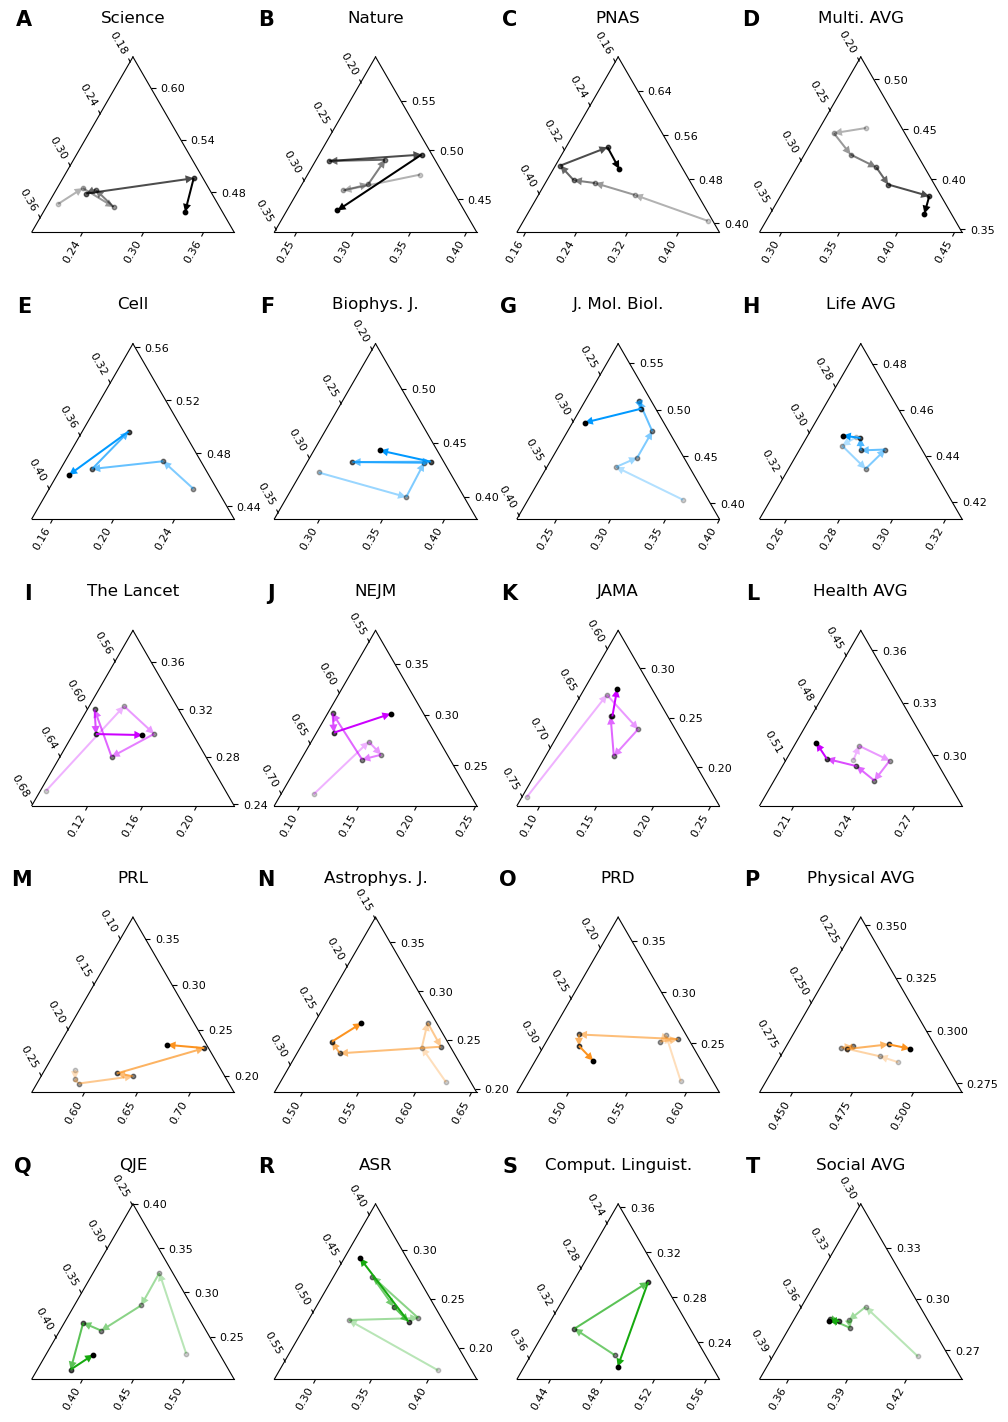

In [6]:
import string
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import mpltern
import numpy as np
import pandas as pd

fig5 = plt.figure(figsize=(12,18))

#------------------------------------------------------------------------#
# 将右边的子图重新排列为 5*3 布局
# 每行三个同领域的期刊，总共五行
ax_list = []
for i in range(20):
    ax = fig5.add_subplot(5, 4, i+1, projection="ternary")
    # set ternary_min according to area
    # if i in [0, 1, 2]:  # 第一行：Multidisciplinary
    #     ax.set_ternary_min(0.40, 0.15, 0.15)
    # elif i in [3, 4, 5]:  # 第二行：Life Science
    #     ax.set_ternary_min(0.4, 0.2, 0.15)
    # elif i in [6, 7, 8]:  # 第三行：Health Science
    #     ax.set_ternary_min(0.15, 0.55, 0.075)
    # elif i in [9, 10, 11]:  # 第四行：Physical Science
    #     ax.set_ternary_min(0.175, 0.05, 0.475)
    # elif i in [12, 13, 14]:  # 第五行：Social Science
    #     ax.set_ternary_min(0.15, 0.2, 0.275)
    ax_list.append(ax)
#------------------------------------------------------------------------#
venue_name_list = ['Science',
                   'Nature',
                   'Proceedings of the National Academy of Sciences of the United States of America', 
                   'Multi_AVG', 

                   'Cell',
                   'Biophysical Journal',
                   'Journal of Molecular Biology',
                   'Life_AVG',
                   
                   'The Lancet',
                   'The New England Journal of Medicine',
                   'JAMA',
                   'Health_AVG',
                   
                   'Physical Review Letters', 
                   'The Astrophysical Journal',
                   'Physical Review D',
                   'Physical_AVG',

                   'Quarterly Journal of Economics',
                   'American Sociological Review',
                   'Computational Linguistics',
                   'Social_AVG',
                  ]
color_dict = {'Science': model.area_color_dict['Multidisciplinary'], 
              'Nature': model.area_color_dict['Multidisciplinary'],
              'Proceedings of the National Academy of Sciences of the United States of America': model.area_color_dict['Multidisciplinary'],
              'Multi_AVG': model.area_color_dict['Multidisciplinary'], 
              
              'Cell': model.area_color_dict['Life Science'],
              'Biophysical Journal': model.area_color_dict['Life Science'],
              'Journal of Molecular Biology': model.area_color_dict['Life Science'],
              'Life_AVG': model.area_color_dict['Life Science'], 
              
              'The Lancet': model.area_color_dict['Health Science'], 
              'The New England Journal of Medicine': model.area_color_dict['Health Science'],
              'JAMA': model.area_color_dict['Health Science'],
              'Health_AVG': model.area_color_dict['Health Science'], 

              'Physical Review Letters': model.area_color_dict['Physical Science'], 
              'The Astrophysical Journal': model.area_color_dict['Physical Science'],
              'Physical Review D': model.area_color_dict['Physical Science'],
              'Physical_AVG': model.area_color_dict['Physical Science'], 

              'Quarterly Journal of Economics': model.area_color_dict['Social Science'],
              'American Sociological Review': model.area_color_dict['Social Science'],
              'Computational Linguistics': model.area_color_dict['Social Science'],
              'Social_AVG': model.area_color_dict['Social Science'], 
             }

tlr_df = pd.DataFrame(columns=['t_list', 'l_list', 'r_list'],
                     index=venue_name_list)
tlr_df.loc[:,'t_list'] = [[] for _ in range(len(tlr_df))]
tlr_df.loc[:,'l_list'] = [[] for _ in range(len(tlr_df))]
tlr_df.loc[:,'r_list'] = [[] for _ in range(len(tlr_df))]

alpha_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0]
for i, ternary_df in enumerate(ternary_df_list):
    for venue_name in venue_name_list:
        try:
            tar_df = ternary_df[ternary_df.venue_name==venue_name]

            tlr_df.loc[venue_name].t_list.append(tar_df.life_cs.values[0])
            tlr_df.loc[venue_name].l_list.append(tar_df.health_cs.values[0])
            tlr_df.loc[venue_name].r_list.append(tar_df.physical_cs.values[0])
        except IndexError:
            pass

        for ax in ax_list:
            if venue_name_list.index(venue_name) == ax_list.index(ax):
                alpha=alpha_list[i]
            else:
                alpha=0.0
            try:
                ax.quiver(tlr_df.loc[venue_name].t_list[-2], 
                          tlr_df.loc[venue_name].l_list[-2], 
                          tlr_df.loc[venue_name].r_list[-2], 
                          tlr_df.loc[venue_name].t_list[-1] - tlr_df.loc[venue_name].t_list[-2], 
                          tlr_df.loc[venue_name].l_list[-1] - tlr_df.loc[venue_name].l_list[-2], 
                          tlr_df.loc[venue_name].r_list[-1] - tlr_df.loc[venue_name].r_list[-2],
                          angles='xy', scale_units='xy', scale=1, 
                          color=color_dict[venue_name], alpha=alpha, 
                          width=0.010, headwidth=4, headlength=4, headaxislength=4)
            except IndexError:
                pass
            try:
                if (venue_name_list.index(venue_name) == ax_list.index(ax)):
                    ax.scatter(tlr_df.loc[venue_name].t_list[-1], 
                               tlr_df.loc[venue_name].l_list[-1], 
                               tlr_df.loc[venue_name].r_list[-1], 
                               s=10, c='k', alpha=alpha)
            except IndexError:
                pass

tlr_df['t_min'] = tlr_df['t_list'].apply(lambda x: min(x) if x else None)
tlr_df['l_min'] = tlr_df['l_list'].apply(lambda x: min(x) if x else None)
tlr_df['r_min'] = tlr_df['r_list'].apply(lambda x: min(x) if x else None)
display(tlr_df)

for i, ax in enumerate(ax_list):
    venue_name = venue_name_list[i]
    ax.set_ternary_min(0.95 * tlr_df.loc[venue_name,'t_min'], 
                       0.95 * tlr_df.loc[venue_name,'l_min'], 
                       0.95 * tlr_df.loc[venue_name,'r_min'])
        
for venue_name in venue_name_list:
    for ax in ax_list:
        if venue_name == 'Proceedings of the National Academy of Sciences of the United States of America':
            label_name = 'PNAS'
        elif venue_name == 'The New England Journal of Medicine':
            label_name = 'NEJM'
        elif venue_name == 'Physical Review Letters':
            label_name = 'PRL'
        elif venue_name == 'Physical Review D':
            label_name = 'PRD'
        elif venue_name == 'The Astrophysical Journal':
            label_name = 'Astrophys. J.'
        elif venue_name == 'Quarterly Journal of Economics':
            label_name = 'QJE'
        elif venue_name == 'American Sociological Review':
            label_name = 'ASR'
        elif venue_name == 'Computational Linguistics':
            label_name = 'Comput. Linguist.'
        elif venue_name == 'Biophysical Journal':
            label_name = 'Biophys. J.'
        elif venue_name == 'Journal of Molecular Biology':
            label_name = 'J. Mol. Biol.'
        elif venue_name == 'Multi_AVG':
            label_name = 'Multi. AVG'
        elif venue_name == 'Life_AVG':
            label_name = 'Life AVG'
        elif venue_name == 'Health_AVG':
            label_name = 'Health AVG'
        elif venue_name == 'Physical_AVG':
            label_name = 'Physical AVG'
        elif venue_name == 'Social_AVG':
            label_name = 'Social AVG'
        else: label_name = venue_name

        if venue_name_list.index(venue_name) == ax_list.index(ax):
                    ax.set_title(label_name, y=1.15, fontweight='normal', fontsize=12, loc='center')

for idx, ax in enumerate(ax_list):
    ax.tick_params(labelsize=8)
    # get the Panel Label (A, B, C...) corresponding to the index
    panel_label = string.ascii_uppercase[idx]
    # add a panel label in the top left corner of each subplot
    ax.text(0.0, 1.27, panel_label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

    # col_idx = idx % 3
    # if col_idx != 0:
    #     ax.taxis.set_ticks([], labels=[])
    #     ax.laxis.set_ticks([], labels=[])
    #     ax.raxis.set_ticks([], labels=[])
    # else:
    #     ax.taxis.set_major_locator(MaxNLocator(nbins=4))
    #     ax.laxis.set_major_locator(MaxNLocator(nbins=4))
    #     ax.raxis.set_major_locator(MaxNLocator(nbins=4))

    ax.taxis.set_major_locator(MaxNLocator(nbins=4))
    ax.laxis.set_major_locator(MaxNLocator(nbins=4))
    ax.raxis.set_major_locator(MaxNLocator(nbins=4))

plt.show()

In [7]:
fig5.savefig('ternary_evolution.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# Arrow examples

In [67]:
abbr_dict = {'Trends in Ecology and Evolution': 'Trends Ecol. Evol.', 
             'Philosophical Transactions of the Royal Society B': 'PTSB',	
             'Ecology Letters': 'Ecol. Lett.',	
             'International Journal of Computer Vision': 'Int. J. Comput. Vis.',
             'Botanical Journal of Scotland': 'Bot. J. Scotl.',
             'Proceedings of The Royal Society B: Biological Sciences': 'PRSB',
             'Journal of Machine Vision and Applications': 'J. Mach. Vis. Appl.',
             'The Journal of Experimental Biology': 'J. Exp. Biol.',
             'Current Topics in Developmental Biology': 'Curr. Top. Dev. Biol.'}

In [68]:
def get_neighbors(venue_name, start_year, end_year, k):
    tar_wv = model.load_wv(start_year, end_year, 100, 10)
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].VenueID.values[0]
    tup_list = tar_wv.most_similar(positive=VID, topn=k)
    neighbor_list = []
    for tup in tup_list:
        neighbor_venue_name = model.MAG_venue_info_df[model.MAG_venue_info_df.VenueID==tup[0]]['OriginalVenue'].values[0]
        similarity = tup[1]
        print(neighbor_venue_name)
        neighbor_list.append(neighbor_venue_name)
    return neighbor_list

2024-11-11 22:53:18 -- start loading word vectors...
2024-11-11 22:53:18 -- word vectors loaded, and its shape is: (5686, 100)
Philosophical Transactions of the Royal Society B
Current Topics in Developmental Biology
The Journal of Experimental Biology
2024-11-11 22:53:18 -- start loading word vectors...
2024-11-11 22:53:18 -- word vectors loaded, and its shape is: (9337, 100)
International Journal of Computer Vision
Botanical Journal of Scotland
Journal of Machine Vision and Applications
2024-11-11 22:53:18 -- start loading word vectors...
2024-11-11 22:53:18 -- word vectors loaded, and its shape is: (15019, 100)
Ecology Letters
Trends in Ecology and Evolution
Philosophical Transactions of the Royal Society B
['Trends in Ecology and Evolution', 'Philosophical Transactions of the Royal Society B', 'Ecology Letters', 'International Journal of Computer Vision', 'Botanical Journal of Scotland', 'Journal of Machine Vision and Applications', 'The Journal of Experimental Biology', 'Current T

,t_list,l_list,r_list
Proceedings of The Royal Society B: Biological Sciences,[0.49011317],[0.27939826],[0.23048858]
Trends in Ecology and Evolution,[],[],[]
Philosophical Transactions of the Royal Society B,[0.5197612],[0.21545933],[0.26477948]
Ecology Letters,[],[],[]
International Journal of Computer Vision,[],[],[]
Botanical Journal of Scotland,[],[],[]
Journal of Machine Vision and Applications,[],[],[]
The Journal of Experimental Biology,[0.49118212],[0.20889622],[0.2999216]
Current Topics in Developmental Biology,[],[],[]


2024-11-11 22:53:18 -- start loading word vectors...
2024-11-11 22:53:18 -- word vectors loaded, and its shape is: (5686, 100)
Philosophical Transactions of the Royal Society B
Current Topics in Developmental Biology
The Journal of Experimental Biology


,t_list,l_list,r_list
Proceedings of The Royal Society B: Biological Sciences,"[0.49011317, 0.53117317]","[0.27939826, 0.14814976]","[0.23048858, 0.32067704]"
Trends in Ecology and Evolution,[0.54860926],[0.11701395],[0.3343768]
Philosophical Transactions of the Royal Society B,"[0.5197612, 0.61398053]","[0.21545933, 0.13622531]","[0.26477948, 0.24979416]"
Ecology Letters,[],[],[]
International Journal of Computer Vision,[0.2781395],[0.22733714],[0.49452344]
Botanical Journal of Scotland,[],[],[]
Journal of Machine Vision and Applications,[0.28234035],[0.2194922],[0.49816748]
The Journal of Experimental Biology,"[0.49118212, 0.48694968]","[0.20889622, 0.23076117]","[0.2999216, 0.28228915]"
Current Topics in Developmental Biology,[],[],[]


2024-11-11 22:53:18 -- start loading word vectors...
2024-11-11 22:53:18 -- word vectors loaded, and its shape is: (9337, 100)
International Journal of Computer Vision
Botanical Journal of Scotland
Journal of Machine Vision and Applications


,t_list,l_list,r_list
Proceedings of The Royal Society B: Biological Sciences,"[0.49011317, 0.53117317, 0.52294564]","[0.27939826, 0.14814976, 0.24956393]","[0.23048858, 0.32067704, 0.22749043]"
Trends in Ecology and Evolution,"[0.54860926, 0.5189914]","[0.11701395, 0.21069416]","[0.3343768, 0.27031443]"
Philosophical Transactions of the Royal Society B,"[0.5197612, 0.61398053, 0.54816294]","[0.21545933, 0.13622531, 0.27309036]","[0.26477948, 0.24979416, 0.17874672]"
Ecology Letters,[0.48067614],[0.2516001],[0.2677237]
International Journal of Computer Vision,"[0.2781395, 0.26857504]","[0.22733714, 0.27313018]","[0.49452344, 0.45829478]"
Botanical Journal of Scotland,[],[],[]
Journal of Machine Vision and Applications,"[0.28234035, 0.24753651]","[0.2194922, 0.2907175]","[0.49816748, 0.46174595]"
The Journal of Experimental Biology,"[0.49118212, 0.48694968, 0.5023443]","[0.20889622, 0.23076117, 0.234398]","[0.2999216, 0.28228915, 0.26325774]"
Current Topics in Developmental Biology,[],[],[]


2024-11-11 22:53:18 -- start loading word vectors...
2024-11-11 22:53:18 -- word vectors loaded, and its shape is: (15019, 100)
Ecology Letters
Trends in Ecology and Evolution
Philosophical Transactions of the Royal Society B


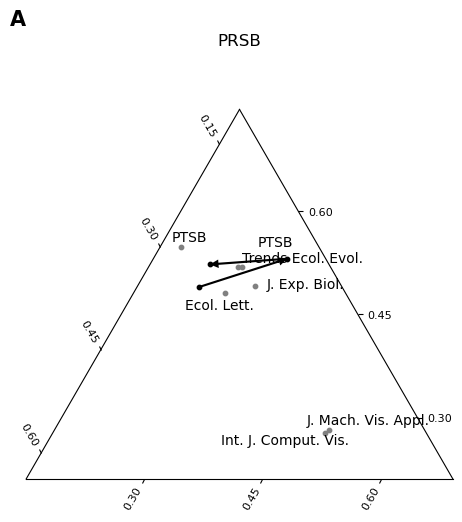

In [87]:
import string
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.ticker import MaxNLocator
import mpltern
import numpy as np
import pandas as pd

fig5 = plt.figure()

#------------------------------------------------------------------------#
ax_list = []
ax = fig5.add_subplot(1, 1, 1, projection="ternary")
ax_list.append(ax)
#------------------------------------------------------------------------#
venue_name_list = ['Proceedings of The Royal Society B: Biological Sciences']
color_dict = {'Proceedings of The Royal Society B: Biological Sciences': model.area_color_dict['Multidisciplinary'],}
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']

neighbor_list = []
for venue_name in venue_name_list:
    for i in range(len(start_year_list[2:5])):
        for neighbor in get_neighbors(venue_name, start_year_list[2:5][i], end_year_list[2:5][i], 3):
            neighbor_list.append(neighbor)
neighbor_list = list(set(neighbor_list))
print(neighbor_list)

tlr_df = pd.DataFrame(columns=['t_list', 'l_list', 'r_list'],
                     index=venue_name_list+neighbor_list)
tlr_df.loc[:,'t_list'] = [[] for _ in range(len(tlr_df))]
tlr_df.loc[:,'l_list'] = [[] for _ in range(len(tlr_df))]
tlr_df.loc[:,'r_list'] = [[] for _ in range(len(tlr_df))]

alpha_list = [1, 1, 1, 1, 1, 1, 1]
texts = []
for i, ternary_df in enumerate(ternary_df_list[2:5]):
    for venue_name in venue_name_list:
        try:
            tar_df = ternary_df[ternary_df.venue_name==venue_name]

            tlr_df.loc[venue_name].t_list.append(tar_df.life_cs.values[0])
            tlr_df.loc[venue_name].l_list.append(tar_df.health_cs.values[0])
            tlr_df.loc[venue_name].r_list.append(tar_df.physical_cs.values[0])
        except IndexError:
            pass

        for neighbor in neighbor_list:
            try:
                tar_df = ternary_df[ternary_df.venue_name==neighbor]

                tlr_df.loc[neighbor].t_list.append(tar_df.life_cs.values[0])
                tlr_df.loc[neighbor].l_list.append(tar_df.health_cs.values[0])
                tlr_df.loc[neighbor].r_list.append(tar_df.physical_cs.values[0])
            except IndexError:
                pass

        display(tlr_df)

        for ax in ax_list:
            if venue_name_list.index(venue_name) == ax_list.index(ax):
                alpha=alpha_list[i]
            else:
                alpha=0.0
            try:
                ax.quiver(tlr_df.loc[venue_name].t_list[-2], 
                          tlr_df.loc[venue_name].l_list[-2], 
                          tlr_df.loc[venue_name].r_list[-2], 
                          tlr_df.loc[venue_name].t_list[-1] - tlr_df.loc[venue_name].t_list[-2], 
                          tlr_df.loc[venue_name].l_list[-1] - tlr_df.loc[venue_name].l_list[-2], 
                          tlr_df.loc[venue_name].r_list[-1] - tlr_df.loc[venue_name].r_list[-2],
                          angles='xy', scale_units='xy', scale=1, 
                          color=color_dict[venue_name], alpha=alpha, 
                          width=0.005, headwidth=4, headlength=4, headaxislength=4)
            except IndexError:
                pass
            try:
                if (venue_name_list.index(venue_name) == ax_list.index(ax)):
                    ax.scatter(tlr_df.loc[venue_name].t_list[-1], 
                                tlr_df.loc[venue_name].l_list[-1], 
                                tlr_df.loc[venue_name].r_list[-1], 
                                s=10, c='k', alpha=alpha)
                    current_neighbor_list = get_neighbors(venue_name, start_year_list[2:5][i], end_year_list[2:5][i], 3)
                    for neighbor in current_neighbor_list:
                        try:
                            ax.scatter(tlr_df.loc[neighbor].t_list[-1], 
                                        tlr_df.loc[neighbor].l_list[-1], 
                                        tlr_df.loc[neighbor].r_list[-1], 
                                        s=10, c='gray', alpha=alpha)
                            texts.append(ax.text(tlr_df.loc[neighbor].t_list[-1], 
                                                    tlr_df.loc[neighbor].l_list[-1], 
                                                    tlr_df.loc[neighbor].r_list[-1], 
                                                    abbr_dict[neighbor], ha='center', va='center'))
                        except IndexError:
                            pass
            except IndexError:
                pass

tlr_df['t_min'] = tlr_df['t_list'].apply(lambda x: min(x) if x else None)
tlr_df['l_min'] = tlr_df['l_list'].apply(lambda x: min(x) if x else None)
tlr_df['r_min'] = tlr_df['r_list'].apply(lambda x: min(x) if x else None)

for i, ax in enumerate(ax_list):
    venue_name = venue_name_list[i]
    ax.set_ternary_min(0.85 * tlr_df.t_min.min(), 
                       0.85 * tlr_df.l_min.min(), 
                       0.85 * tlr_df.r_min.min())
        
for venue_name in venue_name_list:
    for ax in ax_list:
        if venue_name == 'Proceedings of The Royal Society B: Biological Sciences':
            label_name = 'PRSB'
        else: label_name = venue_name

        if venue_name_list.index(venue_name) == ax_list.index(ax):
                    ax.set_title(label_name, y=1.15, fontweight='normal', fontsize=12, loc='center')

for idx, ax in enumerate(ax_list):
    ax.tick_params(labelsize=8)
    # get the Panel Label (A, B, C...) corresponding to the index
    panel_label = string.ascii_uppercase[idx]
    # add a panel label in the top left corner of each subplot
    ax.text(0.0, 1.27, panel_label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='right')

    ax.taxis.set_major_locator(MaxNLocator(nbins=4))
    ax.laxis.set_major_locator(MaxNLocator(nbins=4))
    ax.raxis.set_major_locator(MaxNLocator(nbins=4))

adjust_text(texts);
plt.show()

In [79]:
texts

[Text(0.2337196130082202, 0.5729599060950341, 'Trends Ecol. Evol.'),
 Text(0.08991965108821831, 0.6383311810431542, 'PTSB'),
 Text(0.20758194700871613, 0.5054632722041307, 'Trends Ecol. Evol.'),
 Text(-0.04635244708320685, 0.572513586514956, 'PTSB'),
 Text(-0.01233604376434383, 0.4563255546154914, 'Ecol. Lett.'),
 Text(-0.006731531629367238, 0.24693002084116913, 'Int. J. Comput. Vis.')]

# Check the Pole vectors 

In [21]:
def cal_pole_vec(start_year, end_year):
    model.load_wv(start_year, end_year, 100, 10)
    VIDs = model.wv.index_to_key
    vectors = model.wv.get_normed_vectors()
    
    vec_df = pd.DataFrame(list(zip(VIDs, vectors)), columns =['VID', 'vector'])
    VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
    vec_df = vec_df.loc[vec_df.VID.isin(VID_labeled['VID'])]
    vec_df['label'] = VID_labeled['label']
    
    vec_df.loc[vec_df.label.isin(['Agricultural and Biological Sciences', 
                                  'Biochemistry, Genetics and Molecular Biology', 
                                  'Immunology and Microbiology', 
                                  'Neuroscience', 
                                  'Pharmacology, Toxicology and Pharmaceutics']), 'area'] = 'Life Science'
    vec_df.loc[vec_df.label.isin(['Medicine', 
                                  'Nursing',
                                  'Veterinary',
                                  'Dentistry',
                                  'Health Professions']), 'area'] = 'Health Science'
    vec_df.loc[vec_df.label.isin(['Chemical Engineering',
                                  'Chemistry',
                                  'Computer Science',
                                  'Earth and Planetary Sciences',
                                  'Energy',
                                  'Engineering',
                                  'Environmental Science',
                                  'Material Science',
                                  'Mathematics',
                                  'Physics and Astronomy']), 'area'] = 'Physical Science'
    vec_df.loc[vec_df.label.isin(['Arts and Humanities',
                                  'Business, Management and Accounting',
                                  'Decision Sciences',
                                  'Economics, Econometrics and Finance',
                                  'Psychology',
                                  'Social Sciences']), 'area'] = 'Social Science'
    vec_df.loc[vec_df.label=='Multidisciplinary', 'area'] = 'Multidisciplinary'
    
    pole_life = vec_df[vec_df.area == 'Life Science'].vector.mean()
    pole_health = vec_df[vec_df.area == 'Health Science'].vector.mean()
    pole_physical = vec_df[vec_df.area == 'Physical Science'].vector.mean()

    return vec_df, [pole_life, pole_health, pole_physical]
    

/tmp/ipykernel_3889807/4279106987.py:4: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax2, ax3, ax4, ax5, ax6, ax7)


2024-01-16 15:03:24 -- start loading word vectors...
2024-01-16 15:03:24 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:03:24 -- start loading VID_labeled...
2024-01-16 15:03:24 -- finish.
2024-01-16 15:03:25 -- start loading word vectors...
2024-01-16 15:03:25 -- word vectors loaded, and its shape is: (3116, 100)
2024-01-16 15:03:25 -- start loading VID_labeled...
2024-01-16 15:03:25 -- finish.
2024-01-16 15:03:25 -- start loading word vectors...
2024-01-16 15:03:25 -- word vectors loaded, and its shape is: (5686, 100)
2024-01-16 15:03:25 -- start loading VID_labeled...
2024-01-16 15:03:25 -- finish.
2024-01-16 15:03:25 -- start loading word vectors...
2024-01-16 15:03:25 -- word vectors loaded, and its shape is: (9337, 100)
2024-01-16 15:03:25 -- start loading VID_labeled...
2024-01-16 15:03:25 -- finish.
2024-01-16 15:03:25 -- start loading word vectors...
2024-01-16 15:03:25 -- word vectors loaded, and its shape is: (15019, 100)
2024-01-16 15:03:25 -- start loa

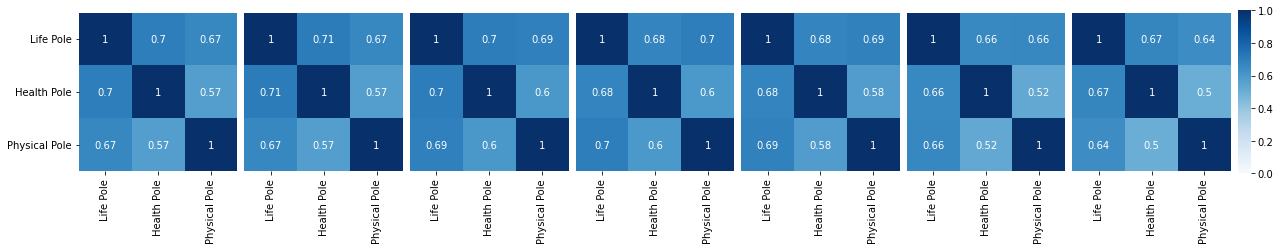

In [102]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, axcb) = plt.subplots(1,8, gridspec_kw={'width_ratios':[1, 1, 1, 1, 1, 1, 1, 0.08],
                                                                              'wspace': 0.05
                                                                             }, figsize=(21,3))
ax1.get_shared_y_axes().join(ax2, ax3, ax4, ax5, ax6, ax7)
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, axcb]

for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    vec_df, pole_list = cal_pole_vec(start_year, end_year)
    cs_df = pd.DataFrame(cosine_similarity(pole_list), 
                         columns=['Life Pole', 'Health Pole', 'Physical Pole'], 
                         index=['Life Pole', 'Health Pole', 'Physical Pole'])
    
    if i == len(model.start_year_list)-7:
        ax = sns.heatmap(cs_df, annot=True, vmin=0, cbar=False, cmap='Blues', square=True, ax = ax_list[i-15])
    else: 
        if i != len(model.start_year_list)-1:
            ax = sns.heatmap(cs_df, annot=True, vmin=0, cbar=False, cmap='Blues', square=True, ax = ax_list[i-15])
            
        if i == len(model.start_year_list)-1:
            ax = sns.heatmap(cs_df, annot=True, vmin=0, cmap='Blues', square=True, ax = ax_list[i-15], cbar_ax=axcb)
            
        ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

In [91]:
def make_random_pole_vec(start_year, end_year):
    model.load_wv(start_year, end_year, 100, 10)
    VIDs = model.wv.index_to_key
    vectors = model.wv.get_normed_vectors()
    
    vec_df = pd.DataFrame(list(zip(VIDs, vectors)), columns =['VID', 'vector'])
    VID_labeled = model.load_VID_labeled(start_year, end_year, 100, 10)
    vec_df = vec_df.loc[vec_df.VID.isin(VID_labeled['VID'])]
    vec_df['label'] = VID_labeled['label']
    
    vec_df.loc[vec_df.label.isin(['Agricultural and Biological Sciences', 
                                  'Biochemistry, Genetics and Molecular Biology', 
                                  'Immunology and Microbiology', 
                                  'Neuroscience', 
                                  'Pharmacology, Toxicology and Pharmaceutics']), 'area'] = 'Life Science'
    vec_df.loc[vec_df.label.isin(['Medicine', 
                                  'Nursing',
                                  'Veterinary',
                                  'Dentistry',
                                  'Health Professions']), 'area'] = 'Health Science'
    vec_df.loc[vec_df.label.isin(['Chemical Engineering',
                                  'Chemistry',
                                  'Computer Science',
                                  'Earth and Planetary Sciences',
                                  'Energy',
                                  'Engineering',
                                  'Environmental Science',
                                  'Material Science',
                                  'Mathematics',
                                  'Physics and Astronomy']), 'area'] = 'Physical Science'
    vec_df.loc[vec_df.label.isin(['Arts and Humanities',
                                  'Business, Management and Accounting',
                                  'Decision Sciences',
                                  'Economics, Econometrics and Finance',
                                  'Psychology',
                                  'Social Sciences']), 'area'] = 'Social Science'
    vec_df.loc[vec_df.label=='Multidisciplinary', 'area'] = 'Multidisciplinary'

    pole_1 = vec_df.sample(len(vec_df[vec_df.area == 'Life Science']), replace=False).vector.mean()
    pole_2 = vec_df.sample(len(vec_df[vec_df.area == 'Health Science']), replace=False).vector.mean()
    pole_3 = vec_df.sample(len(vec_df[vec_df.area == 'Physical Science']), replace=False).vector.mean()

    return vec_df, pole_1, pole_2, pole_3
    

/tmp/ipykernel_3889807/3666065646.py:3: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax2, ax3, ax4, ax5, ax6, ax7)


2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start loading VID_labeled...
2024-01-16 15:01:38 -- finish.
2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start loading VID_labeled...
2024-01-16 15:01:38 -- finish.
2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start loading VID_labeled...
2024-01-16 15:01:38 -- finish.
2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start loading VID_labeled...
2024-01-16 15:01:38 -- finish.
2024-01-16 15:01:38 -- start loading word vectors...
2024-01-16 15:01:38 -- word vectors loaded, and its shape is: (1645, 100)
2024-01-16 15:01:38 -- start load

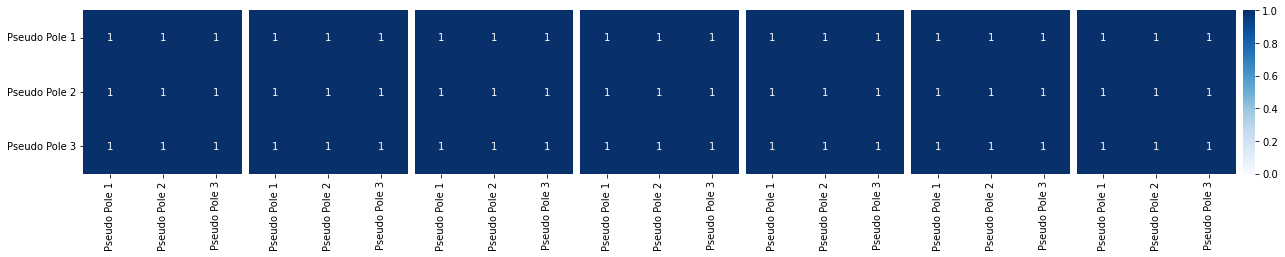

In [101]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, axcb) = plt.subplots(1,8, gridspec_kw={'width_ratios':[1, 1, 1, 1, 1, 1, 1, 0.08],
                                                                              'wspace': 0.05}, figsize=(21,3))
ax1.get_shared_y_axes().join(ax2, ax3, ax4, ax5, ax6, ax7)
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, axcb]

for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
    start_year, end_year = model.start_year_list[i], model.end_year_list[i]
    pseudo_pole_df = pd.DataFrame(columns=['pseudo_pole_1', 'pseudo_pole_2', 'pseudo_pole_3'])
    
    for j in range(100):
        vec_df, pole_1, pole_2, pole_3 = make_random_pole_vec(start_year, end_year)
        pseudo_pole_df = pd.concat([pseudo_pole_df, pd.DataFrame({'pseudo_pole_1':[pole_1], 
                                                                  'pseudo_pole_2':[pole_2], 
                                                                  'pseudo_pole_3':[pole_3]})])
    pole_list = [pseudo_pole_df['pseudo_pole_1'].mean(), 
                 pseudo_pole_df['pseudo_pole_2'].mean(), 
                 pseudo_pole_df['pseudo_pole_3'].mean()]
    cs_df = pd.DataFrame(cosine_similarity(pole_list), 
                         columns=['Pseudo Pole 1', 'Pseudo Pole 2', 'Pseudo Pole 3'], 
                         index=['Pseudo Pole 1', 'Pseudo Pole 2', 'Pseudo Pole 3'])
    
    if i == len(model.start_year_list)-7:
        ax = sns.heatmap(cs_df, annot=True, vmin=0, cbar=False, cmap='Blues', ax = ax_list[i-15])
    else: 
        if i != len(model.start_year_list)-1:
            ax = sns.heatmap(cs_df, annot=True, vmin=0, cbar=False, cmap='Blues', ax = ax_list[i-15])
            
        if i == len(model.start_year_list)-1:
            ax = sns.heatmap(cs_df, annot=True, vmin=0, cmap='Blues', ax = ax_list[i-15], cbar_ax=axcb)
            
        ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')